# MRM for Fraud in Finance

In [1]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import typing
from typing import Union, Tuple, Dict, List, Type


# Models
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from fraudmrm.mlp import BinaryMLP1L
from fraudmrm.utils import train_mlp, test_mlp
#import xgboost as xgb
#from xgboost import XGBClassifier

# Preprocess model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, CountEncoder
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTENC#, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model performance metrics
from sklearn.metrics import (
    recall_score, precision_score, 
    f1_score, precision_recall_curve, 
    roc_auc_score, roc_curve
)

# Explainability
# import shap
# from lime.lime_tabular import LimeTabularExplainer
# from sklearn.inspection import permutation_importance
# from sklearn.inspection import PartialDependenceDisplay
# from sklearn import tree


# Others
import logging
import pickle
import importlib

In [2]:
FIG_PATH = '../figures/'
RESULTS_PATH = '../results/'
PATH = '~/mrm_fraud/datasets/TabFormer/'

# Load data

In [3]:
def loadTabFormer(path, year=[]):
    # Load data
    df = pd.concat([pd.read_csv(path+'card_transaction.v1-'+str(y)+'.csv') for y in year])
    df.reset_index(drop=True, inplace=True)
    df.sort_values(by='transactionTime', inplace=True)
    # Convert variables
    df.transactionTime = pd.to_datetime(df.transactionTime)
    df.MerchantName = df.MerchantName.astype(str)
    df.MCC = df.MCC.astype(str)
    df.UseChip = df.UseChip.astype(str)
    df.Zip = df.Zip.astype(int).astype(str)
    
    return df

In [4]:
def fraud_summary(data: pd.DataFrame,
                  tw: str=None, 
                  trxTime_col: str=None, 
                  trxAmount_col: str=None, 
                  isFraud_col: set=None) -> pd.DataFrame:
    summary = data.groupby(pd.Grouper(key=trxTime_col, freq=tw)).agg(
        total_transactions=(trxAmount_col, "count"),
        total_fraud_cases=(isFraud_col, "sum"),
        total_fraud_value=(trxAmount_col, lambda x: x[x.index.isin(df.loc[df[isFraud_col] == 1].index)].sum()),
        total_transaction_value=(trxAmount_col, "sum"),
    )#.set_index(trxTime_col)
    return summary

In [5]:
def plot_fraud(df_fraud_summary: pd.DataFrame):

    axis_label_fs = 9
    axis_tick_fs = 8
    legend_fs = 8
    title_fs = 9
    
    fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

    # Variables
    x = df_fraud_summary.index
    fraud_cases = df_fraud_summary.total_fraud_cases
    fraud_value = df_fraud_summary.total_fraud_value
    num_trx = df_fraud_summary.total_transactions
    trx_val = df_fraud_summary.total_transaction_value
    
    # Number and value of fraud
    ax[0].bar(x, fraud_cases, width=20, label='Fraud cases')
    ax01 = ax[0].twinx()
    ax01.plot(x, fraud_value/1e3, c='tab:red', marker='o', label='Fraud value')
    
    # Class imbalance
    fraud_imb = 100*fraud_cases/num_trx
    ax[1].plot(x, fraud_imb, color='k')
    
    # Total number of transactions
    ax[2].bar(x, num_trx/1e3, width=20, color='C2')
    
    
    # Formatting
    
    ax[0].set_ylabel('No. of fraud', fontsize=axis_label_fs)
    ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=legend_fs)
    ax[0].set_title('(a)', fontsize=title_fs, loc='left')
    ax01.set_ylabel('Fraud value '+r'$(\times 10^3 \$)$', fontsize=axis_label_fs)
    ax01.legend(loc='upper left', bbox_to_anchor=(0.01, 0.83), fontsize=legend_fs)
    
    ax[1].grid(axis='both')
    ax[1].set_title('(b)', loc='left', fontsize=title_fs)
    ax[1].set_ylabel('Class imbalance (%)', fontsize=axis_label_fs)
    
    ax[2].set_ylabel('No. of transactions '+r'$(\times 10^3)$', fontsize=axis_label_fs)
    ax[2].set_title('(c)', loc='left', fontsize=title_fs)
    ax[2].set_xlabel('Time', fontsize=axis_label_fs)
    
    
    ax[0].set_xticks(x, x, rotation=90, fontsize=axis_tick_fs)
    # ax01.set_yticks(np.arange(7), np.arange(7))
    ax[1].set_xticks(x, x, rotation=90, fontsize=axis_tick_fs)
    # if tw == 'week':
    #     xindex = x.index.date
    #     [x.index.date if tw=='week' else x.index]
    ax[2].set_xticks(x.date, x.date, rotation=90, fontsize=axis_tick_fs)
    
    ax[0].tick_params(labelsize=axis_tick_fs)
    ax01.tick_params(labelsize=axis_tick_fs)
    ax[1].tick_params(labelsize=axis_tick_fs)
    ax[2].tick_params(labelsize=axis_tick_fs)
    
    # xlim=[1996, 2019]
    # ax[0].set_xlim(xlim)
    # ax[0].set_xlim(xlim)
    
    plt.subplots_adjust(hspace=0.3)
    # plt.savefig(fig_folder+'TabFormer_dataset.png', bbox_inches='tight', dpi=300)
    plt.show()

In [6]:
%%time
df = loadTabFormer(PATH, year=[2007, 2008, 2009])

CPU times: user 5.91 s, sys: 799 ms, total: 6.71 s
Wall time: 6.79 s


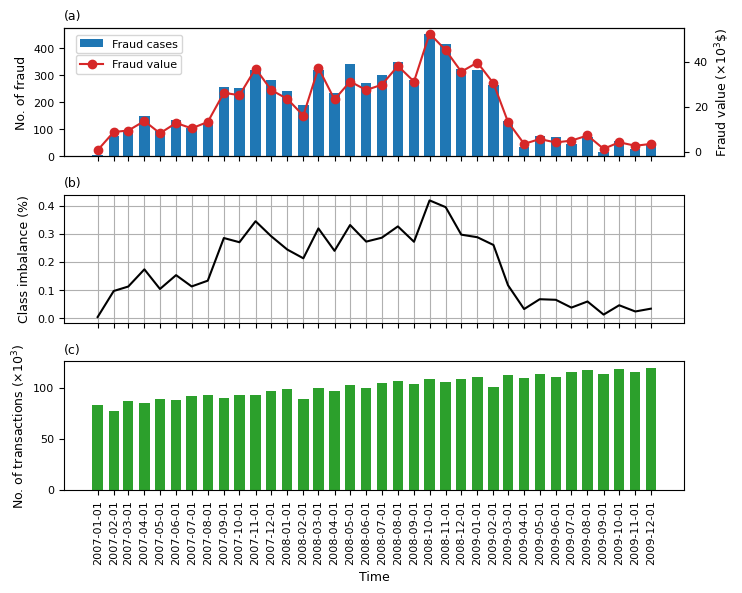

In [7]:
df_fraud_summary = fraud_summary(df, 
                                 tw='1MS', 
                                 trxTime_col='transactionTime', 
                                 trxAmount_col='Amount', 
                                 isFraud_col='isFraud')    
plot_fraud(df_fraud_summary)

Remove months with too low or with no fraud cases

In [8]:
df = df.loc[(df.transactionTime >= pd.Timestamp(2007, 8, 1)) & 
                                 (df.transactionTime < pd.Timestamp(2009, 2, 1))]

In [9]:
print(f'Total number of months: {df.transactionTime.dt.to_period('M').nunique()}')

Total number of months: 18


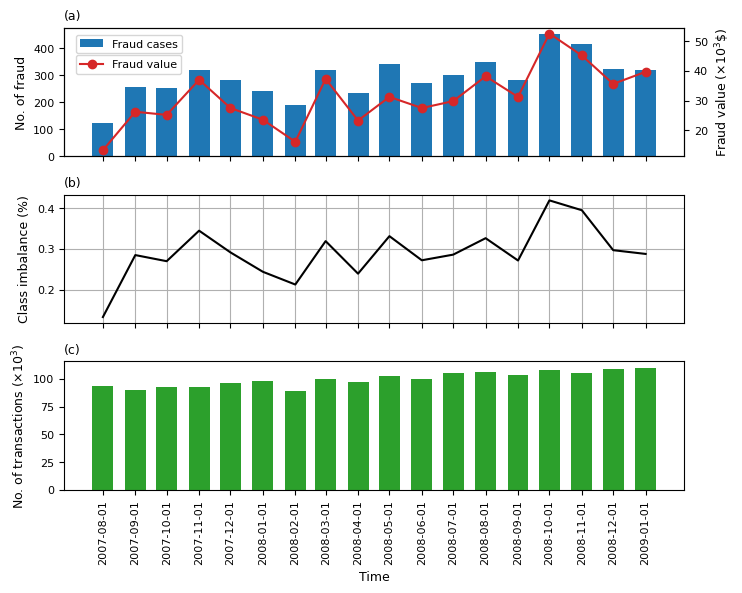

In [10]:
df_fraud_summary = fraud_summary(df, 
                                 tw='1MS', 
                                 trxTime_col='transactionTime', 
                                 trxAmount_col='Amount', 
                                 isFraud_col='isFraud')    
plot_fraud(df_fraud_summary)

# Define features

In [9]:
print('All variables:\n')
for i in df.columns.to_list():
    print(i if i != 'isFraud' else '')

All variables:

transactionTime
year
month
weekday
hour
User
Card
Amount
UseChip
MerchantName
MerchantCity
MerchantState
Zip
MCC
Error



In [11]:
# Rolling time window for user lever patterns
time_window='7D'

# --- Predictors

# Numerical variables
numerical_vars = ['Amount']
# Frequency encoding variables
freq_enc_vars = ['hour']
# Target encoding variables
target_enc_vars = ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC', 'Error']
# One-hot encoding variables
onehot_enc_vars = ['weekday', 'UseChip']
# Categorical variables
cat_vars = freq_enc_vars+target_enc_vars+onehot_enc_vars
# List of all predictors before encoding
var_cols = numerical_vars+freq_enc_vars+target_enc_vars+onehot_enc_vars
# Geographical features for class imbalance oversampling (if used)
geo_vars = ['MerchantName', 'Zip', 'MerchantCity', 'MerchantState']

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Feature engineering

In [6]:
# --- Feature engineering ---

def convert_to_numeric(df, feature):
    featureStr_to_featureNum = {iStr:iNum for iNum, iStr in enumerate(df[feature].unique())}
    return df[feature].map(featureStr_to_featureNum)
    
def feature_engineering(df):
    ''' Create new variables from data variables. '''

    # Convert 'MerchantCity' to numeric 'MerchantCityNum'
    df['MerchantCityNum'] = convert_to_numeric(df, 'MerchantCity')

    # Convert 'MerchantState' to numeric 'MerchantStateNum'
    df['MerchantStateNum'] = convert_to_numeric(df, 'MerchantState')

    # User level patterns
    dfnew = pd.DataFrame()
    for _ , gdata in df.groupby('User'):
        
        # Transaction patterns
        gdata['userTxMean'] = gdata.rolling(time_window, on='transactionTime')['Amount'].mean()
        gdata['userTxMedian'] = gdata.rolling(time_window, on='transactionTime')['Amount'].median()
        gdata['userTxStd'] = gdata.rolling(time_window, on='transactionTime')['Amount'].std().fillna(0)
        gdata['userTxMax'] = gdata.rolling(time_window, on='transactionTime')['Amount'].max()
        gdata['userTxMin'] = gdata.rolling(time_window, on='transactionTime')['Amount'].min()
        gdata['userTxFreq'] = gdata.rolling(time_window, on='transactionTime')['Amount'].count()
    
        # Merchant patterns
        gdata['userMerchant'] = gdata.rolling(time_window, on='transactionTime')['MerchantName'].apply(lambda x: x.nunique())
        gdata['userMCC'] = gdata.rolling(time_window, on='transactionTime')['MCC'].apply(lambda x: x.nunique())
    
        # Geographical patterns
        gdata['userCity'] = gdata.rolling(time_window, on='transactionTime')['MerchantCityNum'].apply(lambda x: x.nunique())
        gdata['userState'] = gdata.rolling(time_window, on='transactionTime')['MerchantStateNum'].apply(lambda x: x.nunique())
        gdata['userZip'] = gdata.rolling(time_window, on='transactionTime')['Zip'].apply(lambda x: x.nunique())
        
        dfnew = pd.concat([dfnew, gdata])
    df = dfnew.sort_values(by='transactionTime')

    return df


# Encoding/Scaling

In [12]:
# --- Encoding/Scaling ---
def onehot_transform(df, ohe_vars):
    ''' One-hot encoder. '''
    # Define one-hot encoder
    onehot_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit-transform variables
    df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df[ohe_vars].astype('str')))
    df_onehot.columns = onehot_encoder.get_feature_names_out()
    df_onehot.index = df.index
    
    # Remove original categorical variables
    df.drop(ohe_vars, axis=1, inplace=True)
    
    # Concatenate data set with one-hot columns
    df = pd.concat([df, df_onehot], axis=1)
    return df
def encode_scale_data(X_train, X_test, y_train, numerical_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars):
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    if numerical_vars:
        scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
        scale_cols = numerical_vars+freq_enc_vars+target_enc_vars
        scaler.fit(X_train[scale_cols])
        X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
        X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)
    
    # One-hot encoding
    if onehot_enc_vars:
        X_train = onehot_transform(X_train, onehot_enc_vars)
        X_test = onehot_transform(X_test, onehot_enc_vars)

    return X_train, X_test

# Collinearity

In [47]:
# --- Collinearity ---
def remove_collinearity(X_train, X_test, numerical_vars, target_enc_vars, freq_enc_vars):
    ''' Remove high collinearity with VIF > 10. '''

    # Select columns
    vif_cols = numerical_vars+target_enc_vars+freq_enc_vars
    
    vif_removed_cols=[]
    while True:
        X_train_values = X_train[vif_cols].values
        
        # Variance Inflation Factor
        vif = pd.DataFrame()
        vif['Variable'] = vif_cols
        vif['VIF'] = [variance_inflation_factor(X_train_values, i) for i in range(X_train_values.shape[1])]
        vif = vif[vif.VIF > 10].sort_values(by='VIF', ascending=False)
        if vif.empty:
            break
    
        # Remove column with highest VIF (>10)
        vif_removed_cols.append(vif.iloc[0,0])
        X_train.drop(vif.iloc[0,0], axis=1, inplace=True)
        X_test.drop(vif.iloc[0,0], axis=1, inplace=True)
        vif_cols.remove(vif.iloc[0,0])
        logging.info(f'Remove column {vif.iloc[0,0]} with VIF = {vif.iloc[0,1]}')
        
    return X_train, X_test, vif_removed_cols

# Class imbalance

In [13]:
def combine_geography(df, geo_vars=None):
    df = df.copy()
    var_name = '_'.join(geo_vars)
    df.insert(df.columns.get_loc(geo_vars[0]), var_name, df[geo_vars].agg('_'.join, axis=1))
    df.drop(geo_vars, axis=1, inplace=True)
    return df

def split_geography(df, geo_vars=None):
    var_name = '_'.join(geo_vars)
    idx = df.columns.get_loc(var_name)
    df_split = df[var_name].str.split('_', expand=True)
    df_split.columns = geo_vars
    return pd.concat([df.iloc[:, :idx], df_split, df.iloc[:, idx:]], axis=1).drop(var_name, axis=1)

def aux(X, variables=None, p=False):
    for var in variables:
        print(var, X[var].nunique())
        if p:
            print(X[var].unique())

# Class imbalance
def class_imbalance(X_train, y_train, 
                    over_sample=True,
                    over_sample_ratio='auto',
                    under_sample=True, 
                    under_sample_ratio='auto', 
                    geo_vars=None, 
                    cat_vars=None):

    # Undersample
    if under_sample:
        # Random Under Sampler
        undersampler = RandomUnderSampler(sampling_strategy=under_sample_ratio, random_state=1)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        
    # Oversample
    if over_sample:
        if geo_vars is None:
            raise ValueError("geo_vars cannot be None")
        if cat_vars is None:
            raise ValueError("geo_vars cannot be None")
        # Combine geographical features
        X_train = combine_geography(X_train, geo_vars=geo_vars)
    
        # SMOTENC
        categorical_features = [v for v in cat_vars if v not in geo_vars]+['_'.join(geo_vars)]
        smotenc = SMOTENC(categorical_features=categorical_features, random_state=1)
        X_train, y_train = smotenc.fit_resample(X_train, y_train)
    
        # Split geographical features
        X_train = split_geography(X_train, geo_vars=geo_vars)

    return X_train, y_train

In [64]:
print('Before\n')
print(f'Size of train set: {len(X_train)}\n')
aux(X_train, variables=X_train.columns.to_list())


Before

Size of train set: 206398

Amount 21854
hour 24
MerchantName 7516
MerchantCity 3267
MerchantState 85
Zip 5576
MCC 109
Error 16
weekday 7
UseChip 2


In [87]:
print('After\n')
print(f'Size of train set: {len(X_train)}\n')
aux(X_train, variables=X_train.columns.to_list())


After

Size of train set: 206398

Amount 21854
hour 24
MerchantName 7516
MerchantCity 3267
MerchantState 85
Zip 5576
MCC 109
Error 16
weekday 7
UseChip 2


# main()

In [ ]:
# --- main() function --- 
# def main(transaction_file):

In [12]:
%%time
# Preprocess data
# df = preprocess_data(df)

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 11.2 μs


In [76]:
%%time
# Feature engineering
# df = feature_engineering(df)

CPU times: user 25.7 s, sys: 458 ms, total: 26.2 s
Wall time: 26.2 s


In [109]:
# Split data into Train/Test sets
X, y = df[var_cols], df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [391]:
# %%time
# # Remove collinearity with VIF
# X_train, X_test, vif_removed_cols = remove_collinearity(X_train, X_test, numerical_vars, target_enc_vars, freq_enc_vars)
# logging.info(f'Removed columns due to collinearity: {vif_removed_cols}')

In [110]:
print(f'Class imbalance before: {100*y_train.sum()/len(y_train):.3f}%')

Class imbalance before: 0.280%


In [111]:
%%time
# Class imbalance
X_train, y_train = class_imbalance(X_train, y_train, 
                                   under_sample=True,
                                   under_sample_ratio=0.1,#'not minority', 
                                   over_sample=False,
                                   geo_vars=geo_vars,
                                   cat_vars=cat_vars,
                                  )

CPU times: user 192 ms, sys: 21.4 ms, total: 214 ms
Wall time: 213 ms


In [112]:
print(f'Class imbalance after: {100*y_train.sum()/len(y_train):.3f}%')

Class imbalance after: 9.091%


In [113]:
%%time
# Encode and scale data
X_train, X_test = encode_scale_data(X_train, X_test, y_train, numerical_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

CPU times: user 629 ms, sys: 92.1 ms, total: 721 ms
Wall time: 721 ms


# Define models

In [28]:
# model_dict={}
# model_dict['lr'] = LogisticRegression(class_weight='balanced', max_iter=500, random_state=1)
# # model_dict['rf'] = RandomForestClassifier(n_jobs=5, 
# #                                       random_state=1,
# #                                       criterion='log_loss',
# #                                       class_weight='balanced',
# #                                       verbose=False)
# model_dict['lgbm'] = LGBMClassifier(objective='binary', is_unbalance=True, random_state=1, verbose=-1)
# # model_dict['mlp'] = MLPClassifier(random_state=1)
# # model_dict['skmlp'] = MLPClassifier(random_state=1)
# model_dict['mlp'] = BinaryMLP1L(input_size=X_train.shape[1], 
#                               layer1_size=128,
#                               learning_rate=1e-3, 
#                               max_epochs=200, 
#                               verbose=True, 
#                               random_state=1)

# model_name={'lr':'LR', 'lgbm':'LightGBM', 'mlp':'MLP', 'skmlp':'skMLP'}

# # Type hint
# ModelType = Union[LogisticRegression, LGBMClassifier, BinaryMLP1L]

In [18]:
# Models to be evaluated

logistic = Model(name='LR', 
                 arc=LogisticRegression, 
                 parameters=dict(class_weight='balanced', max_iter=500, random_state=1))

lgbm = Model(name='LGBM', 
             arc=LGBMClassifier,
             parameters=dict(objective='binary', is_unbalance=True, random_state=1, verbose=-1))

mlp = Model(name='mlp', arc=BinaryMLP1L,
            parameters=dict(input_size=X_train.shape[1], 
                            layer1_size=128,
                            learning_rate=1e-3, 
                            max_epochs=100, 
                            verbose=False, 
                            random_state=1))

model_list = [logistic, lgbm, mlp]

In [17]:
# Class of model for evaluation
class Model:
    def __init__(self, name: str, arc: Type[ModelType], parameters: dict):
        """
        Initializes a model instance.

        Args:
        - name (str): The name of the model (e.g., 'LogisticRegression', 'RandomForest').
        - arc (class): The model class (e.g., LogisticRegression, RandomForestClassifier).
        - parameters (dict): The hyperparameters for the model.
        """
        self.name = name
        self.arc = arc
        self.parameters = parameters
        self.instance = None  # Placeholder for the actual model instance

    def __repr__(self):
            params_str = ", \n\t".join(f"{key} = {value}" for key, value in self.parameters.items())
            return (f"Model name: {self.name}\n"
                    f"{self.arc.__name__}(\n\t"
                    f"{params_str})")
        
    def reset(self):
        """Resets the model by re-instantiating it with the given parameters."""
        self.instance = self.arc(**self.parameters)

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """Trains the model on the given training data."""
        if self.instance is None:
            self.reset()
        self.instance.fit(X_train, y_train)

    def predict(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict(X_test)
    
    def predict_proba(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict_proba(X_test)

    def get_model(self):
        """Returns the actual model instance."""
        return self.instance


# Train and Evaluate models

In [19]:
# def model_training(model: Model, X_train: pd.DataFrame, y_train: pd.Series) -> Model:
#     ''' Training the model.
#         Models tested: Logistic Regression, LightLGB, MLP
#     '''
#     model.fit(X_train, y_train)

#     return model

In [20]:
def evaluate_model(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Predictions
    # if model[0] == 'mlp':
        # pred, pred_prob = test_mlp(model[1], X_test, y_test)
    # else:
        # pred, pred_prob = model[1].predict(X_test), model[1].predict_proba(X_test)[:, 1]
    pred, pred_prob = model.predict(X_test), model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics

In [31]:
# %%time
# model=dict()
# metrics=dict()
# for model in model_dict.items():
#     print(f'Training {model[0]}')
#     model_trained = model_training(model, X_train, y_train)
#     metrics[model.name] = evaluate_model(model, X_test, y_test)
#     print('Done\n')

In [47]:
%%time
metrics=dict()
for model in model_list:
    print(f'Training {model.name}')
    model.reset()
    model.fit(X_train, y_train)
    metrics[model.name] = evaluate_model(model, X_test, y_test)
    print('Done\n')

Training LR
Done

CPU times: user 1.84 s, sys: 1.91 s, total: 3.75 s
Wall time: 598 ms


In [50]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, color='C0', lw=2, marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(recall, precision, color=color, marker=marker, lw=lw)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [49]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, model_roc_auc, color='C0', model_name=None, ax=None, 
                   lw=2, title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve
    roc_auc = model_roc_auc

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(fpr, tpr, color=color, lw=lw, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='lower right', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


In [395]:
# --- MISSING ---
    # # Cross-validation
    # cross_validation(model, X_train, y_train)

# Accuracy

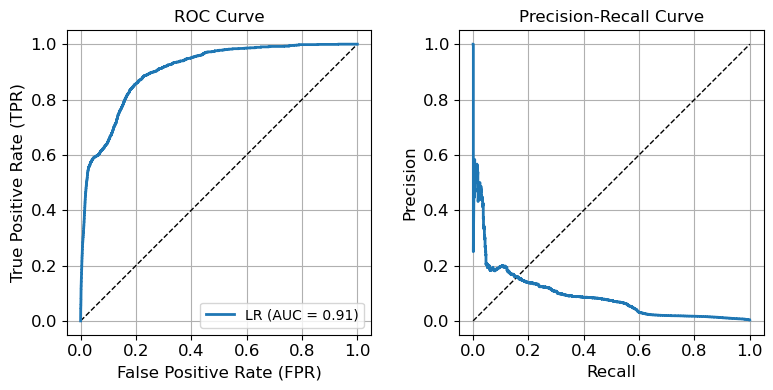

LR  LGBM   MLP
Precision  0.08  0.08  0.08
Recall     0.47  0.47  0.47
F1         0.13  0.13  0.13
ROC-AUC    0.91  0.91  0.91

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, model in enumerate(model_list):
    m = model.name
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=m, color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

models_metrics=[]
for model in model_list:
    m = model.name
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['roc_auc_score']])

display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).round(2).T)

In [102]:
print(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], 
                   index=['LR', 'LGBM', 'MLP']).round(2).T.to_latex())

\begin{tabular}{lrrr}
\toprule
 & LR & LGBM & MLP \\
\midrule
Precision & 0.030000 & 0.080000 & 0.110000 \\
Recall & 0.640000 & 0.600000 & 0.530000 \\
F1 & 0.050000 & 0.140000 & 0.180000 \\
ROC-AUC & 0.910000 & 0.930000 & 0.930000 \\
\bottomrule
\end{tabular}



## Train/Test windows

In [21]:
# General temporal features
df.insert(1, 'month_date', df['transactionTime'].dt.to_period('M'))
df.insert(1, 'week_date', df['transactionTime'].dt.to_period('W-MON'))
df.insert(1, 'day_date', df['transactionTime'].dt.to_period('D'))

df.head()

transactionTime    day_date              week_date month_date  \
599291 2007-08-01 00:01:00  2007-08-01  2007-07-31/2007-08-06    2007-08   
599292 2007-08-01 00:08:00  2007-08-01  2007-07-31/2007-08-06    2007-08   
599293 2007-08-01 00:09:00  2007-08-01  2007-07-31/2007-08-06    2007-08   
599294 2007-08-01 00:17:00  2007-08-01  2007-07-31/2007-08-06    2007-08   
599295 2007-08-01 00:18:00  2007-08-01  2007-07-31/2007-08-06    2007-08   

        year  month  weekday  hour  User  Card  Amount UseChip  \
599291  2007      8        2     0  1497     3  140.00       0   
599292  2007      8        2     0   873     3   24.98       0   
599293  2007      8        2     0   163     3   23.17       1   
599294  2007      8        2     0   583     1  112.10       0   
599295  2007      8        2     0   960     1   46.95       0   

                MerchantName MerchantCity MerchantState    Zip   MCC    Error  \
599291  -4282466774399734331  Crown Point            IN  46307  4829  NoError   
599292   6759623715801000040   Clearwater            FL  33762  5311  NoError   
599293  -2088492411650162548       ONLINE       Missing      0  4784  NoError   
599294  -5467922351692495955      Houston            TX  77048  5912  NoError   
599295    746061614098998133  San Leandro            CA  94577  4121  NoError   

        isFraud  
599291        0  
599292        0  
599293        0  
599294        0  
599295        0

### Protocols

In [22]:
def generate_retrain_lookback_epochs(df: pd.DataFrame, 
                                     period: str=None,
                                     L_tw: int=None,
                                     R_tw: int=None,
                                    ) -> dict[int, dict[str, pd.arrays.PeriodArray]]:
    """ 
        Parameters:
        df (pd.DataFrame): Dataframe of the transactions.
        period (str): Column with the calendar period (D, W, M, Y) to compute the epochs.
        R_tw (int): Retrain time window length.
        L_tw (int): Lookback time window lenght.
    """
    epoch={}

    # Beginning and ending of the dataset
    T0 = df[period].min()
    Tf = df[period].max()

    # First training time
    t0 = T0 + L_tw

    # Number of retrain epochs
    N = int(np.ceil((Tf - t0).n / R_tw))

    for n in range(N):
        t = t0 + n * R_tw
        train_start = t - L_tw
        train_end = t - 1
        test_start = t
        test_end = min(t + (R_tw  - 1), Tf)

        epoch[n] = {}
        epoch[n]['train_start'] = train_start
        epoch[n]['train_end'] = train_end
        epoch[n]['test_start'] = test_start
        epoch[n]['test_end'] = test_end
    
    return epoch

In [23]:
def epoch_train_test_split(df: pd.DataFrame, 
                           period: str, 
                           epoch: Dict[str, pd.arrays.PeriodArray], 
                           var_cols: List[str], 
                           target_var: str,
                          ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Splits dataset into train and test sets for a given epoch."""
    
    # Train set
    train_start = epoch['train_start']
    train_end = epoch['train_end']
    df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
    X_train = df_train[var_cols]
    y_train = df_train[target_var]
    
    # Test set
    test_start = epoch['test_start']
    test_end = epoch['test_end']
    df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
    X_test = df_test[var_cols]
    y_test = df_test[target_var]

    return X_train, X_test, y_train, y_test

In [24]:
def global_eval_tw(df: pd.DataFrame, 
                   period: str=None,
                   tw: int=None, 
                   L_tw: int=None, 
                   R_tw: int=None, 
                   model: Model=None,
                   target_var: str=None,
                   numerical_vars: list[str]=None,
                   target_enc_vars: list[str]=None, 
                   freq_enc_vars: list[str]=None, 
                   onehot_enc_vars: list[str]=None,
                   geo_vars: list[str]=None,
                   under_sample: bool=True,
                   under_sample_ratio: Union[float, str] = 'auto',
                   over_sample: bool=False,
                   over_sample_ratio: Union[float, str] = 'auto',
                  ) -> Tuple[Dict[str, float], int]:
    """Evaluates model performance over retrain and lookback time windows."""

    # All Features
    var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
    # Categorical features
    cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
    # Define epochs for retraining and lookback
    epoch = generate_retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)

    # Model predictions
    pred = []

    # Concatenation of all test sets for each epoch
    global_y_test = []

    # Log of the skipped epochs due to no fraud cases
    skipped_epochs=0
    
    # Evaluate epochs
    for e in epoch:

        # Reset model before training for the current time window
        model.reset()
        
        # Split Train/Test sets
        X_train, X_test, y_train, y_test = epoch_train_test_split(df, period, epoch[e], var_cols, target_var)

        # Skip epochs with no fraud cases in test or train
        if (y_train.sum() == 0) or (y_test.sum() == 0):
            skipped_epochs += 1
            continue
    
        # Class imbalance
        X_train, y_train = class_imbalance(X_train, y_train, 
                                           under_sample=under_sample,
                                           under_sample_ratio=under_sample_ratio, 
                                           over_sample=over_sample,
                                           over_sample_ratio=over_sample_ratio,
                                           geo_vars=geo_vars,
                                           cat_vars=cat_vars
                                          )
        
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
                                            numerical_vars, target_enc_vars, 
                                            freq_enc_vars, onehot_enc_vars)


        # Train model
        # model_trained = model_training(X_train, y_train, model)
        model.fit(X_train, y_train)

        # Model predictions
        pred.append(model.predict(X_test))

        # Global test set
        global_y_test.append(y_test)
    
    # Concatenate results
    # print(pred)
    pred = np.concatenate(pred)
    y_test = pd.concat(global_y_test)
    # print(f'len(pred) = {len(pred)}')
    # print(f'len(pred) = {len(pred)}')

    # Compute metrics
    metrics = {
        'recall': recall_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'f1': f1_score(y_test, pred),
    }
    
    return metrics, skipped_epochs

In [96]:
# def retrain_lookback_matrix(df: pd.DataFrame, tw_min: int=1, tw_max: int=None, options: dict=None):
#     # Skipped epochs
#     skipped_epochs=0
#     # Define matrix size
#     result_matrix = {}
#     # Compute metrics
#     for L in range(tw_min, tw_max+1):
#         for R in range(tw_min, tw_max+1):
#             result_matrix[(L, R)], se = global_eval_tw(df, L_tw = L, R_tw = R, **options)
#             skipped_epochs += se
#             print(L, R)
#     print(f' Skipped Epochs: {skipped_epochs}')
#     return result_matrix

In [41]:
# def retrain_lookback_matrix(df: pd.DataFrame, 
#                             tw_min: int=1, 
#                             tw_max: int=None, 
#                             options: Dict=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
#     """Generates a ndarray of evaluation metrics over paris of different retraining and lookback windows."""

#     if tw_max is None:
#         raise ValueError('Variable tw_max must be assigned an int value.')

#     # Compute metrics for each pair of retrain and lookback time window
#     result_matrix, skipped_epochs = {}, 0
#     for L in range(tw_min, tw_max + 1):
#         for R in range(tw_min, tw_max + 1):
#             # Need to reset models
#             result_matrix[(L, R)], se = global_eval_tw(df, L_tw=L, R_tw=R, **options)
#             skipped_epochs += se
#             # print(f'Processed: Lookback={L}, Retrain={R}')

#     # Convert to numpy array
#     L = tw_max - tw_min + 1
#     score_matrix = dict(recall=np.zeros((L, L)), precision=np.zeros((L, L)), f1=np.zeros((L, L)))
#     for (i, j), metrics in result_matrix.items():
#         score_matrix['recall'][i - tw_min, j - tw_min] = metrics['recall']
#         score_matrix['precision'][i - tw_min, j - tw_min] = metrics['precision']
#         score_matrix['f1'][i - tw_min, j - tw_min] = metrics['f1']
        
#     print(f'Skipped Epochs: {skipped_epochs}')
#     return result_matrix


In [25]:
def retrain_lookback_matrix(df: pd.DataFrame, 
                            tw_min: int=1, 
                            tw_max: int=None, 
                            options: Dict=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generates a ndarray of evaluation metrics over paris of different retraining and lookback windows."""

    if tw_max is None:
        raise ValueError('Variable tw_max must be assigned an int value.')

    # Compute metrics for each pair of retrain and lookback time window
    N = tw_max - tw_min + 1
    score_matrix = dict(recall=np.zeros((N, N)), precision=np.zeros((N, N)), f1=np.zeros((N, N)))
    skipped_epochs = 0
    for L in range(tw_min, tw_max + 1):
        for R in range(tw_min, tw_max + 1):
            # Compute metrics for each pair (Retrain, Lookback)
            metrics, se = global_eval_tw(df, L_tw=L, R_tw=R, **options)
            skipped_epochs += se
            i, j = L-tw_min, R-tw_min
            score_matrix['recall'][i, j] = metrics['recall']
            score_matrix['precision'][i, j] = metrics['precision']
            score_matrix['f1'][i, j] = metrics['f1']
        
    print(f'Skipped Epochs: {skipped_epochs}')
    return score_matrix


In [98]:
# def score_metric_matrix(resultw_matrix, tw_min=1, tw_max=None, score_metric='all'):
#     L = tw_max-tw_min+1
#     if score_metric == 'all':
#         recall_matrix = np.empty((L, L), dtype=float)
#         precision_matrix = np.empty((L, L), dtype=float)
#         f1_matrix = np.empty((L, L), dtype=float)
#         for i in range(L):
#             for j in range(L):
#                 recall_matrix[i, j] = resultw_matrix[(i+tw_min, j+tw_min)]['recall']
#                 precision_matrix[i, j] = resultw_matrix[(i+tw_min, j+tw_min)]['precision']
#                 f1_matrix[i, j] = resultw_matrix[(i+tw_min, j+tw_min)]['f1']
#         return recall_matrix, precision_matrix, f1_matrix
#     else:
#         score_matrix = np.empty((L, L), dtype=float)
#         for i in range(L):
#             for j in range(L):
#                 score_matrix[i, j] = resultw_matrix[(i+tw_min, j+tw_min)][score_metric]
#         return score_matrix

In [55]:
# def score_metric_matrix(result_matrix: Dict[Tuple[int, int], Dict[str, float]], 
#                         tw_min: int, 
#                         tw_max: int) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
#     """Generates numpy matrices for evaluation scores."""

#     L = tw_max - tw_min + 1
#     score_matrix = dict(recall =  np.zeros((L, L)), precision = np.zeros((L, L)), f1 = np.zeros((L, L)))
#     for (i, j), metrics in result_matrix.items():
#         score_matrix['recall'][i - tw_min, j - tw_min] = metrics['recall']
#         score_matrix['precision'][i - tw_min, j - tw_min] = metrics['precision']
#         score_matrix['f1'][i - tw_min, j - tw_min] = metrics['f1']

#     return score_matrix

### Evaluate

In [26]:
# Define parameters of evaluation
tw_min = 1
tw_max = 12
eval_options = dict(
    period='month_date',
    target_var = 'isFraud',
    numerical_vars = numerical_vars,
    target_enc_vars = target_enc_vars,
    freq_enc_vars = freq_enc_vars,
    onehot_enc_vars = onehot_enc_vars,
    geo_vars = geo_vars,
    under_sample=True,
    under_sample_ratio = 0.1,
    over_sample=False,
)

In [29]:
%%time
eval_options['model'] = logistic
logistic_rl_matrix = retrain_lookback_matrix(df, tw_min=tw_min, tw_max=tw_max, options=eval_options)

Skipped Epochs: 0
CPU times: user 11min 33s, sys: 15min 30s, total: 27min 3s
Wall time: 7min 1s


In [176]:
# Save result
with open(RESULTS_PATH+"logistic_rl_matrix.pkl", "wb") as f:
    pickle.dump(logistic_rl_matrix, f)

In [30]:
# Load results
with open(RESULTS_PATH+"logistic_rl_matrix.pkl", "rb") as f:
    logistic_rl_matrix = pickle.load(f)

In [30]:
%%time
eval_options['model'] = lgbm
lgbm_rl_matrix = retrain_lookback_matrix(df, tw_min=tw_min, tw_max=tw_max, options=eval_options)

Skipped Epochs: 0
CPU times: user 30min 13s, sys: 9min 42s, total: 39min 56s
Wall time: 8min 41s


In [181]:
# Save result
with open(RESULTS_PATH+"lgbm_rl_matrix.pkl", "wb") as f:
    pickle.dump(lgbm_rl_matrix, f)

In [29]:
# Load results
with open(RESULTS_PATH+"lgbm_rl_matrix.pkl", "rb") as f:
    lgbm_rl_matrix = pickle.load(f)

In [27]:
%%time
eval_options['model'] = mlp
mlp_rl_matrix = retrain_lookback_matrix(df, tw_min=tw_min, tw_max=tw_max, options=eval_options)

Skipped Epochs: 0
CPU times: user 14h 51min 4s, sys: 1h 10min 39s, total: 16h 1min 44s
Wall time: 2h 10min 41s


In [28]:
# Save result
with open(RESULTS_PATH+"mlp_rl_matrix.pkl", "wb") as f:
    pickle.dump(mlp_rl_matrix, f)

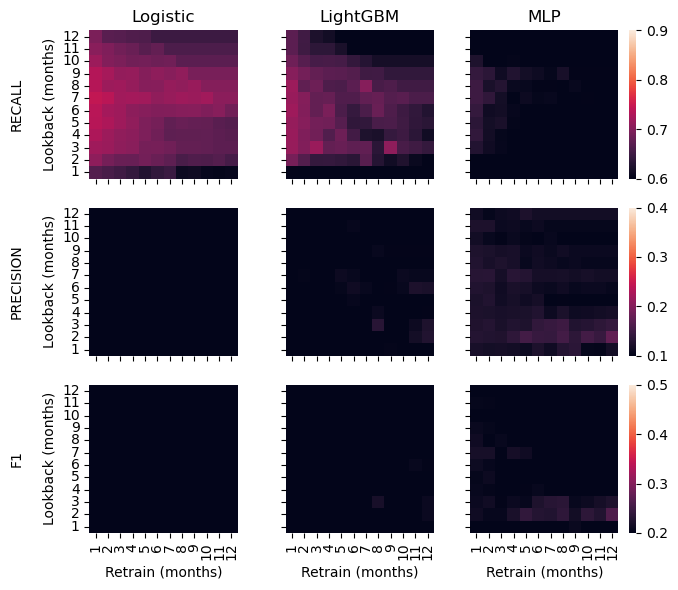

In [31]:
def plot_rl_matrix(rl_matrix: np.ndarray, tw_min, tw_max, col: int=None, cbar=True):

    # Recall
    sns.heatmap(rl_matrix['recall'][::-1], vmin=0.6, vmax=0.9, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[0, col])
    
    # Precision
    sns.heatmap(rl_matrix['precision'][::-1], vmin=0.1, vmax=0.4, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[1, col])
    
    # F1
    sns.heatmap(rl_matrix['f1'][::-1], vmin=0.2, vmax=0.5, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[2, col])
    


fig, ax = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey=True)

# Logistic
plot_rl_matrix(logistic_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=0, cbar=False)
# LGBM
plot_rl_matrix(lgbm_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=1, cbar=False)
# MLP
plot_rl_matrix(mlp_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=2)



# Formatting
ax[0,0].set_title('Logistic', loc='center')
ax[0,0].set_ylabel('RECALL\n\nLookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)
# ax[0,0].text(-0.45, 0.5, 'Recall', va='center', ha='center', fontsize=12, rotation=0, transform=ax[0,0].transAxes)

ax[0,1].set_title('LightGBM', loc='center')

ax[0,2].set_title('MLP', loc='center')

ax[1,0].set_ylabel('PRECISION\n\nLookback (months)')
# ax[1,0].text(-0.45, 0.5, 'Precision', va='center', ha='center', fontsize=12, rotation=0, transform=ax[1,0].transAxes)

ax[2,0].set_ylabel('F1\n\nLookback (months)')
ax[2,0].set_xlabel('Retrain (months)')
# ax[2,0].text(-0.45, 0.5, 'F1', va='center', ha='center', fontsize=12, rotation=0, transform=ax[2,0].transAxes)

ax[2,1].set_xlabel('Retrain (months)')

ax[2,2].set_xlabel('Retrain (months)')

for a in ax.flat:
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

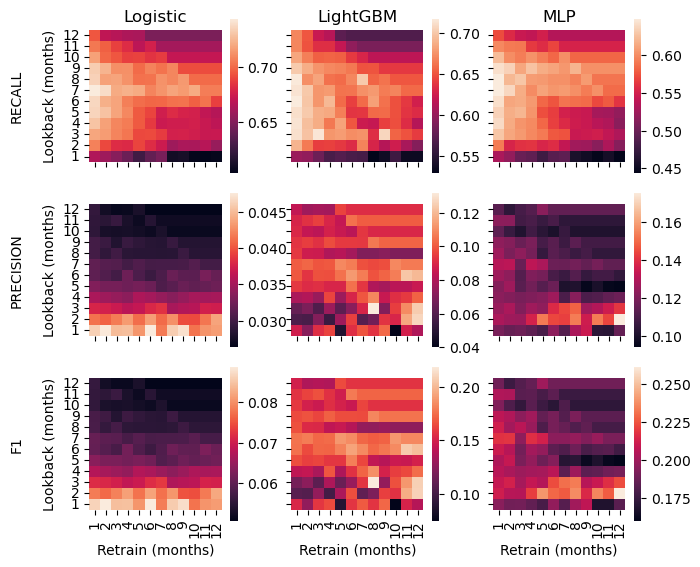

In [33]:
def plot_rl_matrix(rl_matrix: np.ndarray, tw_min, tw_max, col: int=None, cbar=True):

    # Recall
    sns.heatmap(rl_matrix['recall'][::-1],# vmin=0.6, vmax=0.9, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[0, col])
    
    # Precision
    sns.heatmap(rl_matrix['precision'][::-1],# vmin=0.1, vmax=0.4, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[1, col])
    
    # F1
    sns.heatmap(rl_matrix['f1'][::-1],# vmin=0.2, vmax=0.5, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[2, col])
    


fig, ax = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey=True)

# Logistic
plot_rl_matrix(logistic_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=0, cbar=False)
# LGBM
plot_rl_matrix(lgbm_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=1, cbar=False)
# MLP
plot_rl_matrix(mlp_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=2)



# Formatting
ax[0,0].set_title('Logistic', loc='center')
ax[0,0].set_ylabel('RECALL\n\nLookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)
# ax[0,0].text(-0.45, 0.5, 'Recall', va='center', ha='center', fontsize=12, rotation=0, transform=ax[0,0].transAxes)

ax[0,1].set_title('LightGBM', loc='center')

ax[0,2].set_title('MLP', loc='center')

ax[1,0].set_ylabel('PRECISION\n\nLookback (months)')
# ax[1,0].text(-0.45, 0.5, 'Precision', va='center', ha='center', fontsize=12, rotation=0, transform=ax[1,0].transAxes)

ax[2,0].set_ylabel('F1\n\nLookback (months)')
ax[2,0].set_xlabel('Retrain (months)')
# ax[2,0].text(-0.45, 0.5, 'F1', va='center', ha='center', fontsize=12, rotation=0, transform=ax[2,0].transAxes)

ax[2,1].set_xlabel('Retrain (months)')

ax[2,2].set_xlabel('Retrain (months)')

for a in ax.flat:
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

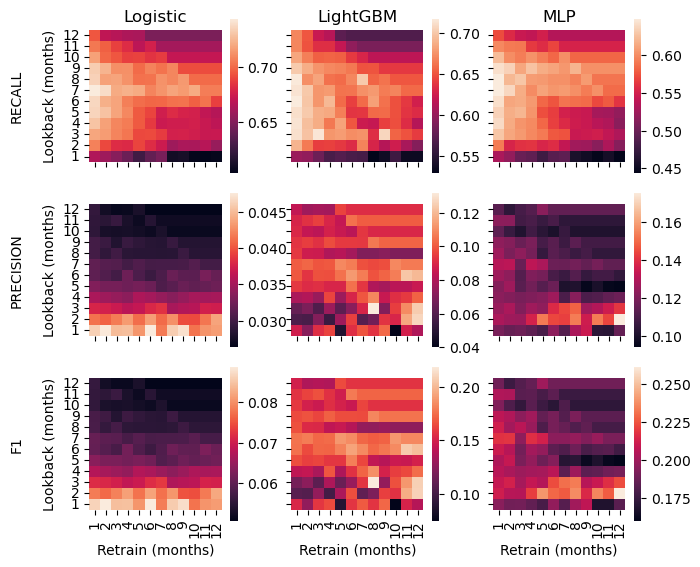

In [40]:
def plot_rl_matrix(rl_matrix: np.ndarray, tw_min, tw_max, col: int=None, cbar=True):

    # Recall
    sns.heatmap(rl_matrix['recall'][::-1],# vmin=0.6, vmax=0.9, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[0, col])
    
    # Precision
    sns.heatmap(rl_matrix['precision'][::-1],# vmin=0.1, vmax=0.4, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[1, col])
    
    # F1
    sns.heatmap(rl_matrix['f1'][::-1],# vmin=0.2, vmax=0.5, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[2, col])
    


fig, ax = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey=True)

# Logistic
plot_rl_matrix(logistic_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=0, cbar=False)
# LGBM
plot_rl_matrix(lgbm_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=1, cbar=False)
# MLP
plot_rl_matrix(mlp_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=2)



# Formatting
ax[0,0].set_title('Logistic', loc='center')
ax[0,0].set_ylabel('RECALL\n\nLookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)
# ax[0,0].text(-0.45, 0.5, 'Recall', va='center', ha='center', fontsize=12, rotation=0, transform=ax[0,0].transAxes)

ax[0,1].set_title('LightGBM', loc='center')

ax[0,2].set_title('MLP', loc='center')

ax[1,0].set_ylabel('PRECISION\n\nLookback (months)')
# ax[1,0].text(-0.45, 0.5, 'Precision', va='center', ha='center', fontsize=12, rotation=0, transform=ax[1,0].transAxes)

ax[2,0].set_ylabel('F1\n\nLookback (months)')
ax[2,0].set_xlabel('Retrain (months)')
# ax[2,0].text(-0.45, 0.5, 'F1', va='center', ha='center', fontsize=12, rotation=0, transform=ax[2,0].transAxes)

ax[2,1].set_xlabel('Retrain (months)')

ax[2,2].set_xlabel('Retrain (months)')

for a in ax.flat:
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

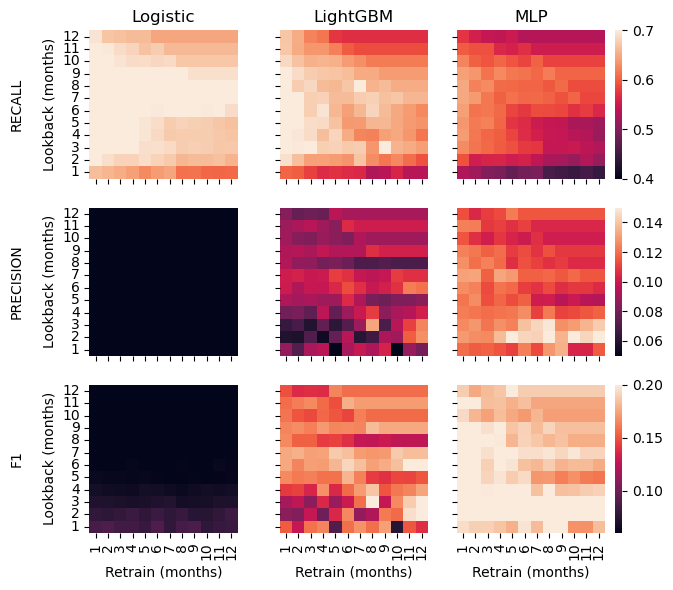

In [39]:
def plot_rl_matrix(rl_matrix: np.ndarray, tw_min, tw_max, col: int=None, cbar=True):

    # Recall
    sns.heatmap(rl_matrix['recall'][::-1], vmin=0.4, vmax=0.7, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[0, col])
    
    # Precision
    sns.heatmap(rl_matrix['precision'][::-1], vmin=0.05, vmax=0.15, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[1, col])
    
    # F1
    sns.heatmap(rl_matrix['f1'][::-1], vmin=0.06, vmax=0.2, cbar=cbar,
                xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
                ax=ax[2, col])
    


fig, ax = plt.subplots(3, 3, figsize=(7, 6), sharex=True, sharey=True)

# Logistic
plot_rl_matrix(logistic_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=0, cbar=False)
# LGBM
plot_rl_matrix(lgbm_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=1, cbar=False)
# MLP
plot_rl_matrix(mlp_rl_matrix, tw_min=tw_min, tw_max=tw_max, col=2)



# Formatting
ax[0,0].set_title('Logistic', loc='center')
ax[0,0].set_ylabel('RECALL\n\nLookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)
# ax[0,0].text(-0.45, 0.5, 'Recall', va='center', ha='center', fontsize=12, rotation=0, transform=ax[0,0].transAxes)

ax[0,1].set_title('LightGBM', loc='center')

ax[0,2].set_title('MLP', loc='center')

ax[1,0].set_ylabel('PRECISION\n\nLookback (months)')
# ax[1,0].text(-0.45, 0.5, 'Precision', va='center', ha='center', fontsize=12, rotation=0, transform=ax[1,0].transAxes)

ax[2,0].set_ylabel('F1\n\nLookback (months)')
ax[2,0].set_xlabel('Retrain (months)')
# ax[2,0].text(-0.45, 0.5, 'F1', va='center', ha='center', fontsize=12, rotation=0, transform=ax[2,0].transAxes)

ax[2,1].set_xlabel('Retrain (months)')

ax[2,2].set_xlabel('Retrain (months)')

for a in ax.flat:
    a.set_aspect('equal')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.show()

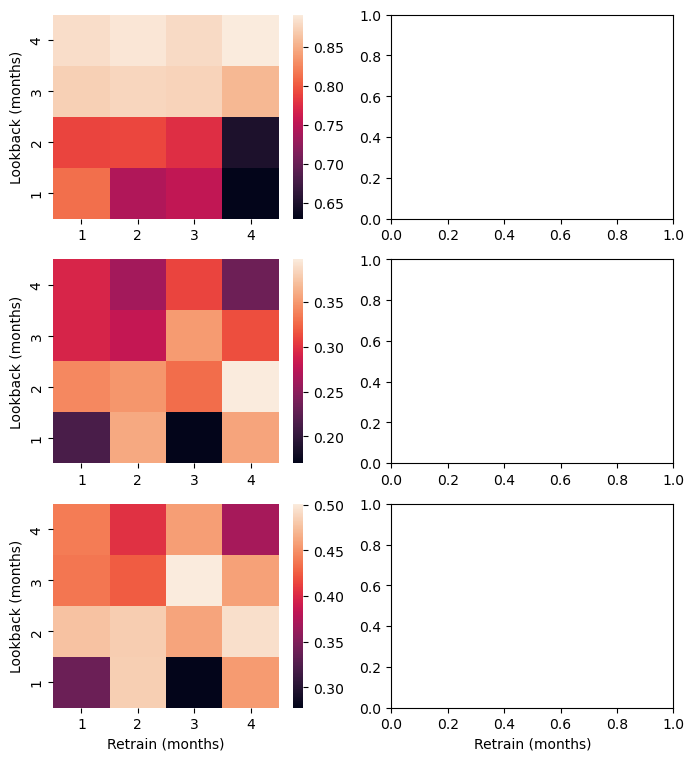

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))



# LGBM test

# Recall
sns.heatmap(recall_matrix_lgbm[::-1], #vmin=0.4, vmax=0.7,
            xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
            ax=ax[0, 0])

# Precision
sns.heatmap(precision_matrix_lgbm[::-1], #vmin=0.01, vmax=0.15,
            xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
            ax=ax[1, 0])

# F1
sns.heatmap(f1_matrix_lgbm[::-1], #vmin=0.05, vmax=0.25,
            xticklabels=np.arange(tw_min, tw_max+1), yticklabels=np.arange(tw_min, tw_max+1)[::-1], 
            ax=ax[2, 0])



# Formatting
ax[0,0].set_ylabel('Lookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)

ax[1, 0].set_ylabel('Lookback (months)')

ax[2, 0].set_ylabel('Lookback (months)')
ax[2, 0].set_xlabel('Retrain (months)')

ax[2, 1].set_xlabel('Retrain (months)')

plt.show()

# HERE

In [41]:
%%time

# Define max/min time windows
tw_min=1
tw_max=12

# Define parameters of evaluation
eval_options = dict(
    period='month_date',
    model=model_dict['lgbm'],
    target_var = 'isFraud',
    numerical_vars = numerical_vars,
    target_enc_vars = target_enc_vars,
    freq_enc_vars = freq_enc_vars,
    onehot_enc_vars = onehot_enc_vars,
    geo_vars = geo_vars,
    under_sample=True,
    under_sample_ratio = 0.05,
    over_sample=False,
)

# Define matrix size
result_matrix_lgbm = {}
# Compute metrics
for L in range(tw_min, tw_max+1):
    for R in range(tw_min, tw_max+1):
        result_matrix_lgbm[(L, R)] = global_eval_tw(df, L_tw = L, R_tw = R, **eval_options)

 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train epochs: 0
   Number of skipped test epochs: 0
 ---------------------------------------
 ------------- Skipped Epochs ----------
   Number of skipped train ep

ValueError: need at least one array to concatenate

In [23]:
recall_matrix_lgbm = np.empty((tw_max, tw_max), dtype=float)
precision_matrix_lgbm = np.empty((tw_max, tw_max), dtype=float)
f1_matrix_lgbm = np.empty((tw_max, tw_max), dtype=float)
for i in range(1, tw_max+1):
    for j in range(1, tw_max+1):
        recall_matrix_lgbm[i-1, j-1] = result_matrix_lgbm[(i, j)]['recall']
        precision_matrix_lgbm[i-1, j-1] = result_matrix_lgbm[(i, j)]['precision']
        f1_matrix_lgbm[i-1, j-1] = result_matrix_lgbm[(i, j)]['f1']

In [24]:
recall_matrix_lr = np.empty((tw_max, tw_max), dtype=float)
precision_matrix_lr = np.empty((tw_max, tw_max), dtype=float)
f1_matrix_lr = np.empty((tw_max, tw_max), dtype=float)
for i in range(1, tw_max+1):
    for j in range(1, tw_max+1):
        recall_matrix_lr[i-1, j-1] = result_matrix_lr[(i, j)]['recall']
        precision_matrix_lr[i-1, j-1] = result_matrix_lr[(i, j)]['precision']
        f1_matrix_lr[i-1, j-1] = result_matrix_lr[(i, j)]['f1']

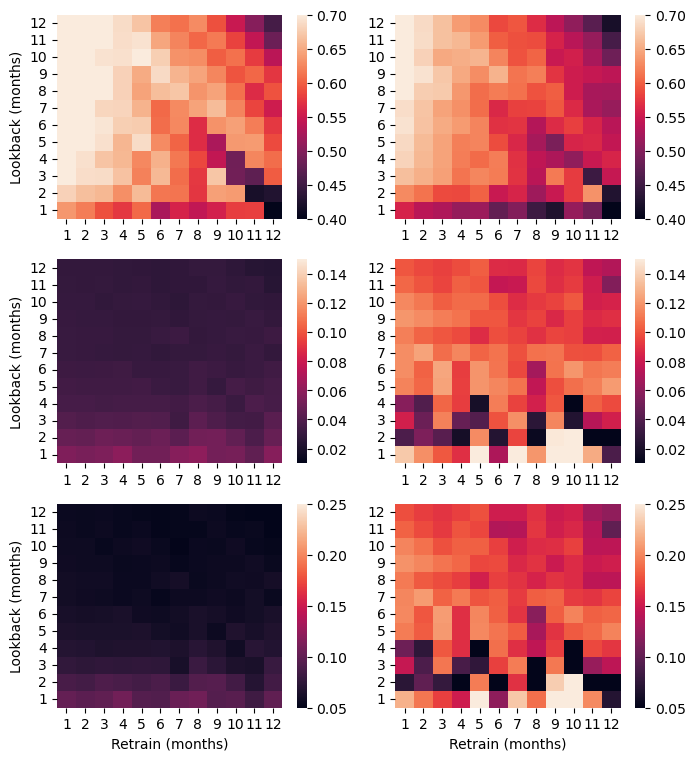

In [71]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))



# Logistic Regression

# Recall
sns.heatmap(recall_matrix_lr[::-1], vmin=0.4, vmax=0.7,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[0, 0])

# Precision
sns.heatmap(precision_matrix_lr[::-1], vmin=0.01, vmax=0.15,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[1, 0])

# F1
sns.heatmap(f1_matrix_lr[::-1], vmin=0.05, vmax=0.25,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[2, 0])

# LightGBM

# Recall
sns.heatmap(recall_matrix_lgbm[::-1], vmin=0.4, vmax=0.7,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[0, 1])

# Precision
sns.heatmap(precision_matrix_lgbm[::-1], vmin=0.01, vmax=0.15,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[1, 1])

# F1
sns.heatmap(f1_matrix_lgbm[::-1], vmin=0.05, vmax=0.25,
            xticklabels=np.arange(1, 13), yticklabels=np.arange(1, 13)[::-1], 
            ax=ax[2, 1])

# Formatting
ax[0,0].set_ylabel('Lookback (months)')
ax[0,0].set_xticklabels(ax[0,0].get_yticklabels()[::-1], rotation=0)

ax[1, 0].set_ylabel('Lookback (months)')

ax[2, 0].set_ylabel('Lookback (months)')
ax[2, 0].set_xlabel('Retrain (months)')

ax[2, 1].set_xlabel('Retrain (months)')

plt.show()

In [122]:
def print_epoch(epoch):
    for E in epoch:
    
        print(f'--- Epoch {E} ---')
        print('Train')
        print(epoch[E]['train_start'])
        print(epoch[E]['train_end'])
        print('Test')
        print(epoch[E]['test_start'])
        print(epoch[E]['test_end'])

x1 [0 1 2 3 4 5 6]
x2 [0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
N = 7.0
Last test length = 0.39999999999999947


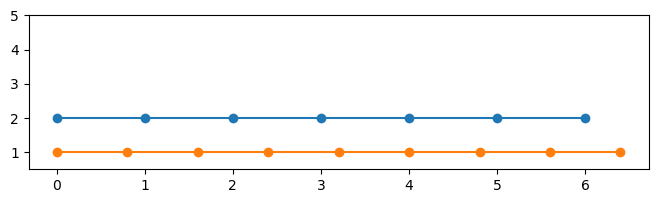

In [166]:
plt.figure(figsize=(8, 2))

T = 6
k = 0.8
x1 = np.arange(0, T+1)
x2 = np.arange(0, T+1, k)
N = np.ceil(T/k)-1
tau_test_final = T - N * k

print('x1', x1)
print('x2', x2)
print(f'N = {N}')
print(f'Last test length = {tau_test_final}')

plt.plot(x1, [2 for i in x1], marker='o')
plt.plot(x2, [1 for i in x2], marker='o')

plt.ylim([0.5, 5])
plt.show()

# Explainability

## Global methods

### SHAP

In [107]:
%%time
shap_values={}
explainer={}
for m in model_dict.keys():
    print(m)
    
    if m == 'mlp':
        pass
        # # Create SHAP Explainer for model
        # X_train_kmeans = shap.kmeans(X_train, 100) # Summarize train set with k mean samples
        # explainer = shap.KernelExplainer(model[m].predict, X_train_kmeans)
        # # Calculate SHAP values
        # shap_values[m] = explainer(X_test)
    else:
        # Create SHAP Explainer for model
        explainer[m] = shap.Explainer(model[m], X_train)
        # Calculate SHAP values
        shap_values[m] = explainer[m](X_test)
        
    print('ok')

lr
ok
lgbm


 99%|===================| 50830/51600 [00:54<00:00]        

ok
mlp
ok
CPU times: user 54.5 s, sys: 189 ms, total: 54.7 s
Wall time: 54.7 s


In [170]:
lr_featImportance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': model['lr'].coef_[0]
}).sort_values(by='Coefficients', ascending=True)

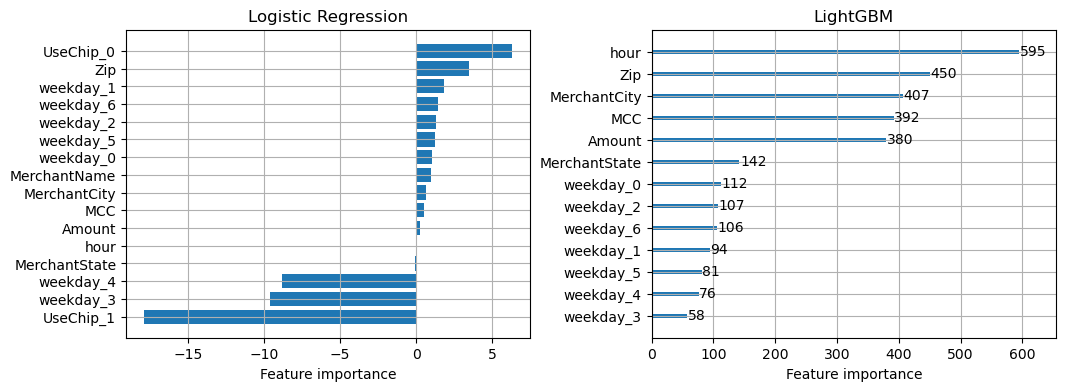

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].barh(lr_featImportance.Feature, lr_featImportance.Coefficients)
ax[0].set_title('Logistic Regression')
ax[0].set_xlabel('Feature importance')
ax[0].grid()

lgb.plot_importance(model_dict['lgbm'], importance_type='auto', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('LightGBM')

plt.subplots_adjust(wspace=0.3)

lr
lgbm


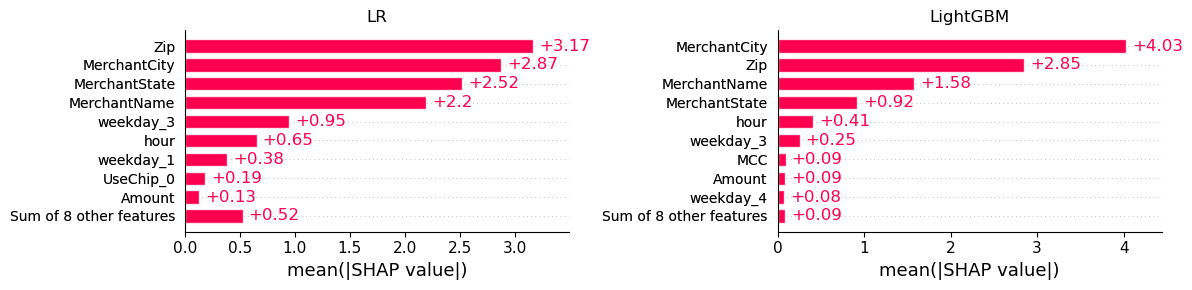

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        shap.plots.bar(shap_values[m], ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

lr
lgbm


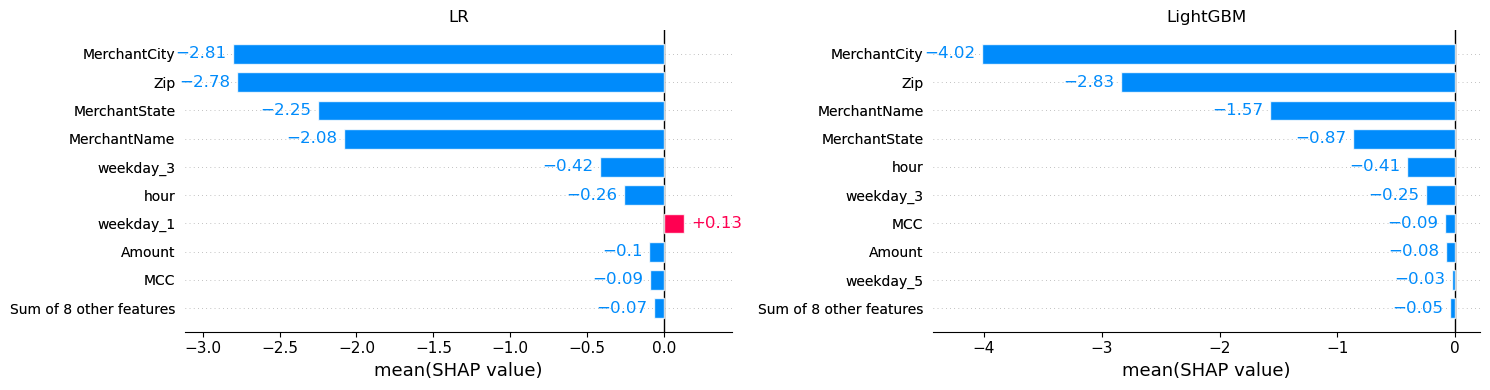

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))


# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        # shap.plots.bar(shap_values[m].min(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].max(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].abs.mean(0), ax=ax[i], show=False)
        shap.plots.bar(shap_values[m].mean(0), ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

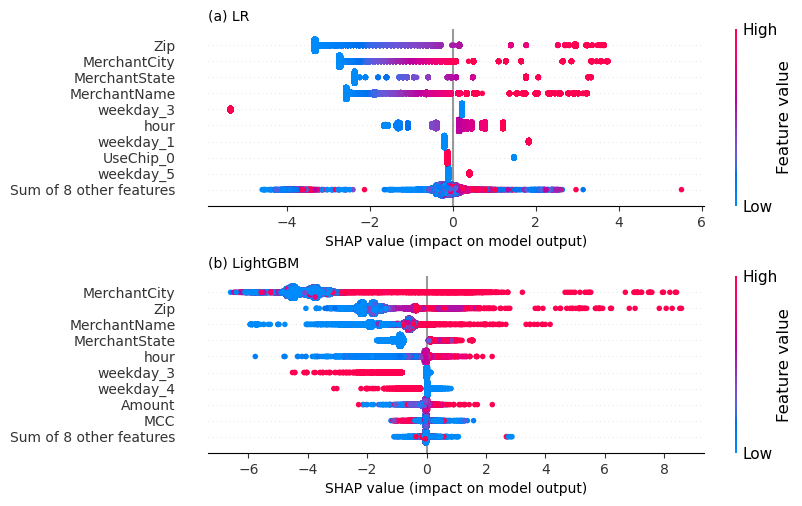

In [109]:
plt.figure(figsize=(12, 10))

title={0:'(a) ', 1:'(b) '}
for i, m in enumerate(['lr', 'lgbm']):
    plt.subplot(2, 1, i+1)
    shap.plots.beeswarm(shap_values[m], show=False)
    plt.title(title[i]+model_name[m], loc='left', fontsize=10)
    plt.tick_params(axis='both', labelsize=10)
    plt.gca().xaxis.label.set_size(10)
plt.subplots_adjust(hspace=0.4)
plt.savefig(fig_folder+'shap_values.png', dpi=300, bbox_inches='tight')
plt.show()

### Permutation Importance

In [110]:
def get_perm_imp(X, y, model_dict, scoring=None, n_reps=30, n_samples=1.0, random_state=1):
    perm_imp={}
    for m in model_dict:
        perm_imp[m] = permutation_importance(model_dict[m], X, y, 
                                             scoring=scoring,
                                             n_repeats=n_reps, 
                                             max_samples=n_samples, 
                                             random_state=random_state)
    return perm_imp

In [111]:
def plot_perm_imp(perm_imp, ax=None, model_name=None):

    sorted_importances_idx = perm_imp.importances_mean.argsort()
    importances = pd.DataFrame(
        perm_imp.importances[sorted_importances_idx].T,
        columns=X_test.columns[sorted_importances_idx],
    )
    importances.plot.box(vert=False, whis=10, ax=ax)
    ax.axvline(x=0, color="k", linestyle="--")

In [112]:
%%time
perm_imp = get_perm_imp(X_test, y_test, model_dict, scoring=['recall', 'precision'], 
                        n_reps=30, 
                        n_samples=1.0
                       )

CPU times: user 5min 1s, sys: 2min 19s, total: 7min 20s
Wall time: 47.7 s


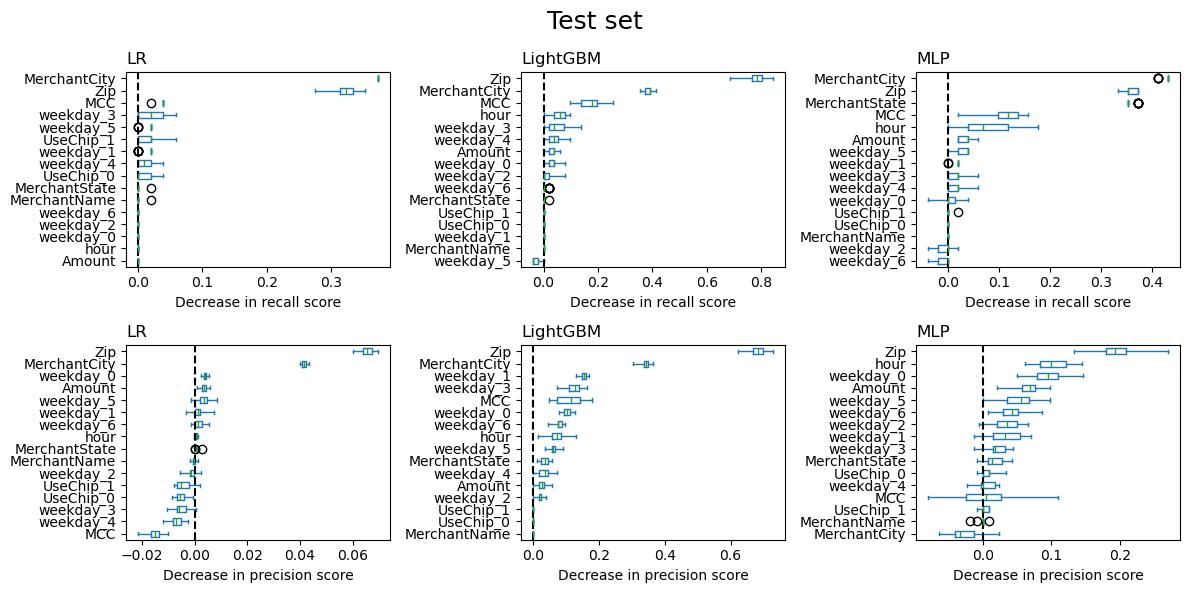

In [399]:
fig, ax = plt.subplots(len(scoring), len(perm_imp.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

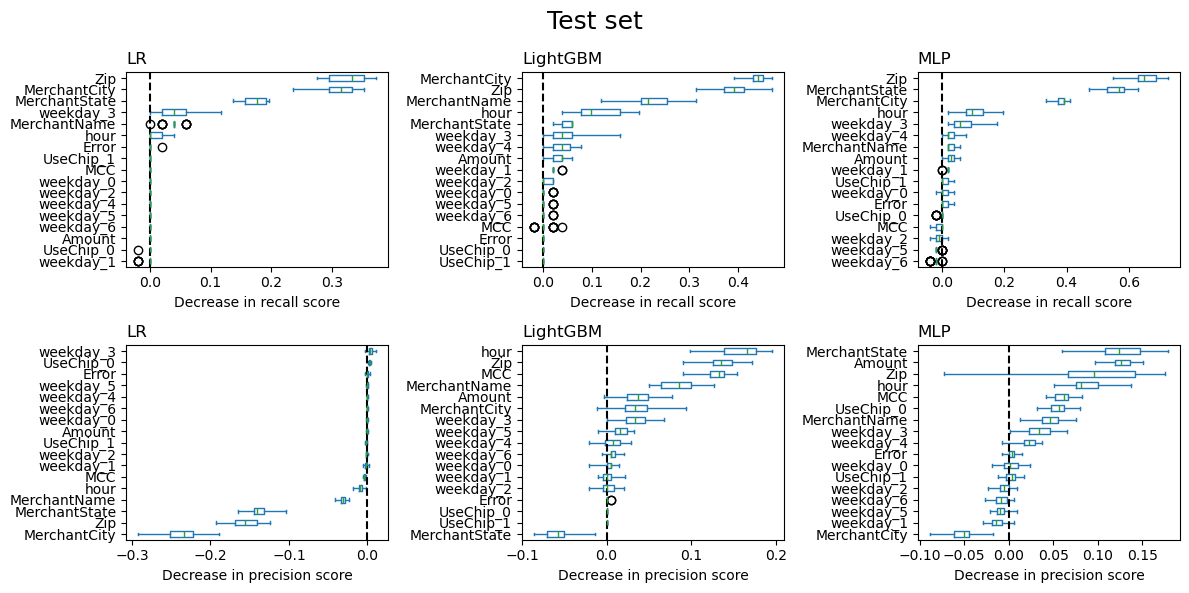

In [113]:
scoring=['recall', 'precision']
fig, ax = plt.subplots(len(scoring), len(perm_imp.keys()), figsize=(12, 6))

for j, m in enumerate(['lr', 'lgbm', 'mlp']):
    for i, metric in enumerate(scoring):
        plot_perm_imp(perm_imp[m][metric], model_name=model_name[m], ax=ax[i, j])
        ax[i,j].set_title(model_name[m], loc='left')
        ax[i,j].set_xlabel('Decrease in '+metric+' score')
        # ax[i,j].figure.tight_layout()
fig.suptitle('Test set', y=0.98, fontsize=18)
plt.tight_layout()
plt.savefig(fig_folder+'permutation_importance_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [154]:
m = 'lr'
s = 'recall'
for s in scoring:
    peImp = perm_imp[m][s]
    table_perm_imp=[]
    for i in peImp.importances_mean.argsort()[::-1][:3]:
        table_perm_imp.append([X_test.columns[i], str(peImp.importances_mean[i].round(3))+' +/- '+str(peImp.importances_std[i].round(3))])
    display(pd.DataFrame(table_perm_imp).set_index(0).rename_axis(None).rename(columns={1:s}))

recall
Zip            0.381 +/- 0.035
MerchantCity   0.324 +/- 0.025
MerchantState  0.138 +/- 0.015

precision
weekday_3  0.004 +/- 0.003
UseChip_0  0.003 +/- 0.001
weekday_6      0.0 +/- 0.0

In [420]:
for i in permimp.importances_mean.argsort()[::-1]:
    # if permimp.importances_mean[i] - 2 * permimp.importances_std[i] > 0:
    print(f"{X_test.columns[i]:<8}"
          f"\t{permimp.importances_mean[i]:.3f}"
          f" +/- {permimp.importances_std[i]:.3f}")

Zip     	0.767 +/- 0.031
MerchantCity	0.382 +/- 0.018
MCC     	0.159 +/- 0.045
hour    	0.049 +/- 0.024
weekday_3	0.045 +/- 0.038
weekday_4	0.033 +/- 0.018
Amount  	0.029 +/- 0.010
weekday_0	0.020 +/- 0.018
MerchantState	0.018 +/- 0.006
weekday_6	0.014 +/- 0.018
weekday_2	0.010 +/- 0.013
weekday_1	0.002 +/- 0.006
UseChip_1	0.000 +/- 0.000
UseChip_0	0.000 +/- 0.000
MerchantName	0.000 +/- 0.000
weekday_5	-0.037 +/- 0.006


### PDP

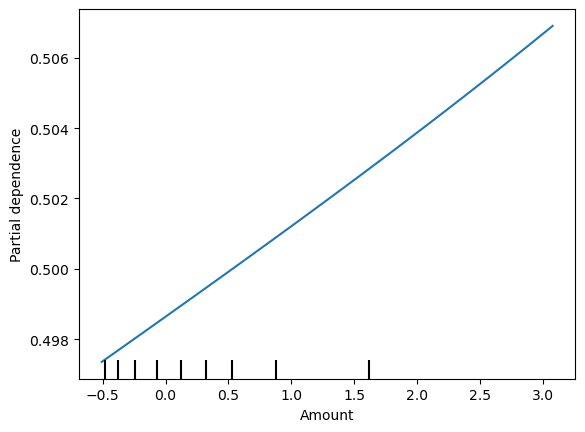

In [542]:
m='lr'
features_pdp ={
    'features': ['Amount'],
    # 'categorical_features':['MCC']
} 

PartialDependenceDisplay.from_estimator(model_dict[m], X_train, **features_pdp)

### Global Surrogate model

In [114]:
class GlobalSurrogate:
    def __init__(self, surrogate, blackbox):
        self.surrogate = surrogate
        self.blackbox = blackbox
        self.is_fitted = False

    def fit(self, X_train):
        blackbox_predict_proba_train = self.blackbox.predict_proba(X_train)[:, 1]
        self.surrogate.fit(X_train, (blackbox_predict_proba_train > 0.5).astype(int))
        self.is_fitted = True

    def predict_proba(self, X):
        if not self.is_fitted:
            raise ValueError("Surrogate model is not fitter. Call 'fit' before making preditions.")
        return self.surrogate.predict_proba(X)[:, 1]

    def r2(self, X_test):
        if not self.is_fitted:
            raise ValueError("Surrogate model is not fitter. Call 'fit' before evaluation.")
        surrogate_predict_proba_test = self.predict_proba(X_test)
        blackbox_predict_proba_test = self.blackbox.predict_proba(X_test)[:, 1]
        return r2_score(surrogate_predict_proba_test, blackbox_predict_proba_test)

In [203]:
r2_surrogate = []
lr_surrogate = dict()
dt_surrogate = dict()
for m in ['lr', 'lgbm', 'mlp']:
    # Logistic regression
    lr_surrogate[m] = GlobalSurrogate(surrogate=LogisticRegression(random_state=1), blackbox=model[m])
    lr_surrogate[m].fit(X_train)
    # Decision tree
    dt_surrogate[m] = GlobalSurrogate(surrogate=DecisionTreeClassifier(max_depth=3, random_state=1), blackbox=model[m])
    dt_surrogate[m].fit(X_train)

    r2_surrogate.append([model_name[m], lr_surrogate[m].r2(X_test), dt_surrogate[m].r2(X_test)])
display(pd.DataFrame(r2_surrogate, columns=['', 'LR', 'DT']).set_index(''))

LR        DT
                            
LR        0.942522  0.783650
LightGBM  0.182925  0.128059
MLP       0.400364  0.273082

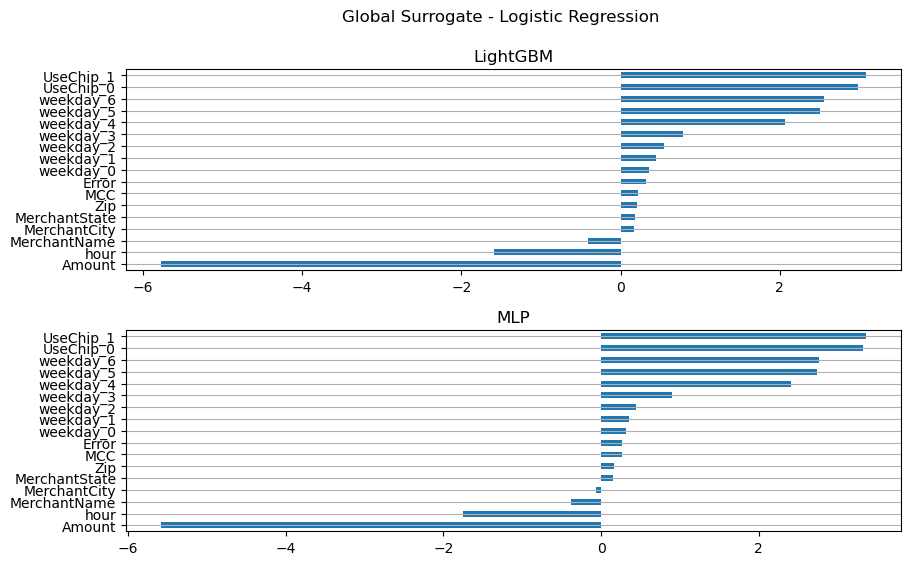

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, m in enumerate(list(model.keys())[1:]):
    # LR surrogate
    pd.DataFrame([X_train.columns, lr_surrogate[m].surrogate.coef_[0]], 
                 index=['Features', 'LRcoeff']).T.sort_values(by='LRcoeff').plot(kind='barh', legend=False, 
                                                                                 title=model_name[m], ax=ax[i])
    ax[i].set_yticklabels(X_train.columns)
    ax[i].grid(axis='y')

plt.subplots_adjust(hspace=0.3)
fig.suptitle('Global Surrogate - Logistic Regression')
plt.show()

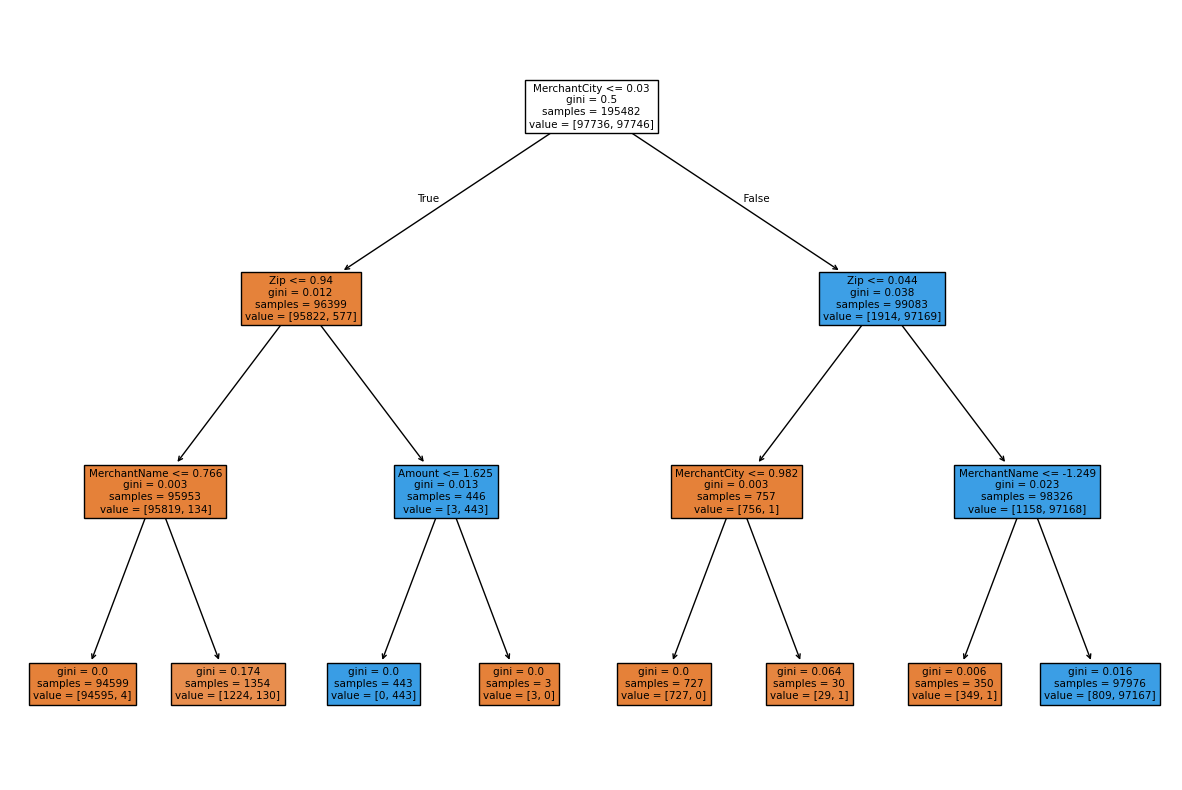

In [146]:
fig, ax = plt.subplots(figsize=(15, 10))
tree.plot_tree(dt_surrogate['lgbm'].surrogate,
               feature_names=X_train.columns,
               max_depth=3, 
               filled=True
              )

plt.show()

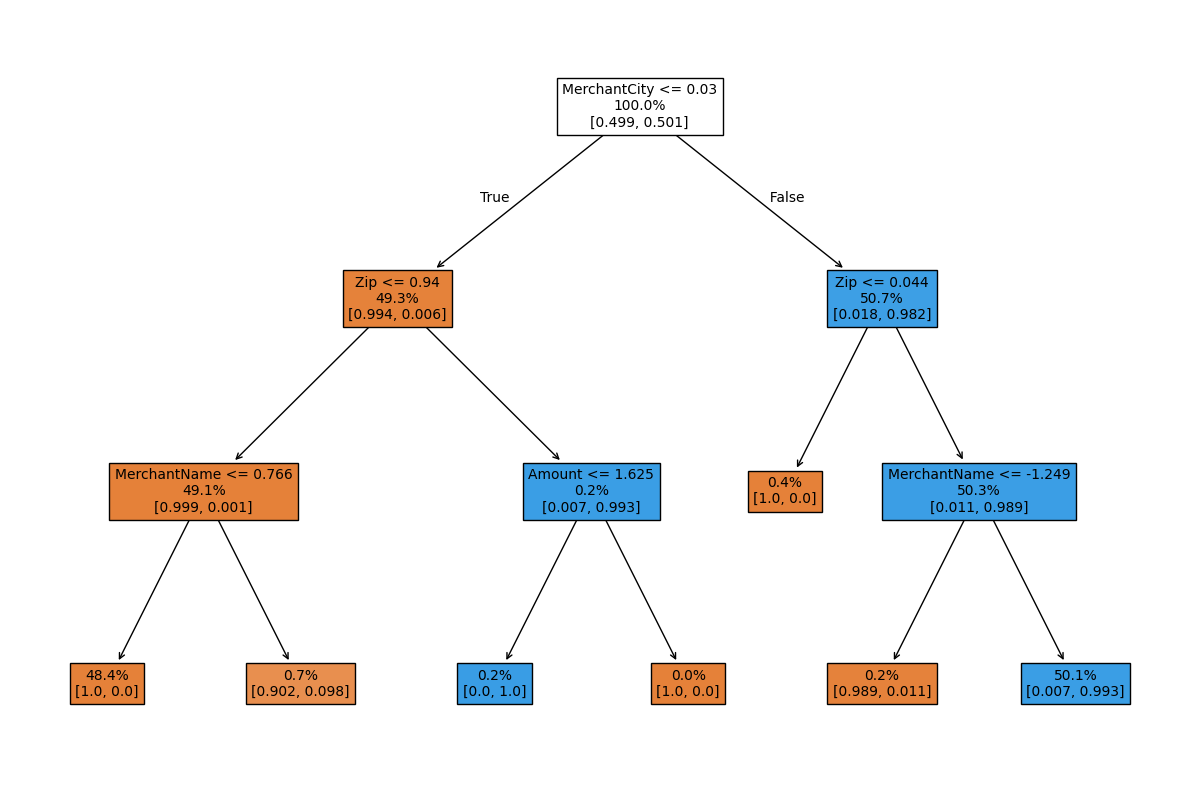

In [147]:
fig, ax = plt.subplots(figsize=(15, 10))
tree.plot_tree(dt_surrogate['mlp'].surrogate,
               feature_names=X_train.columns,
               max_depth=3,
               filled=True,
               impurity=False,
               label='none',
               proportion=True,
               class_names=None
              )

plt.show()

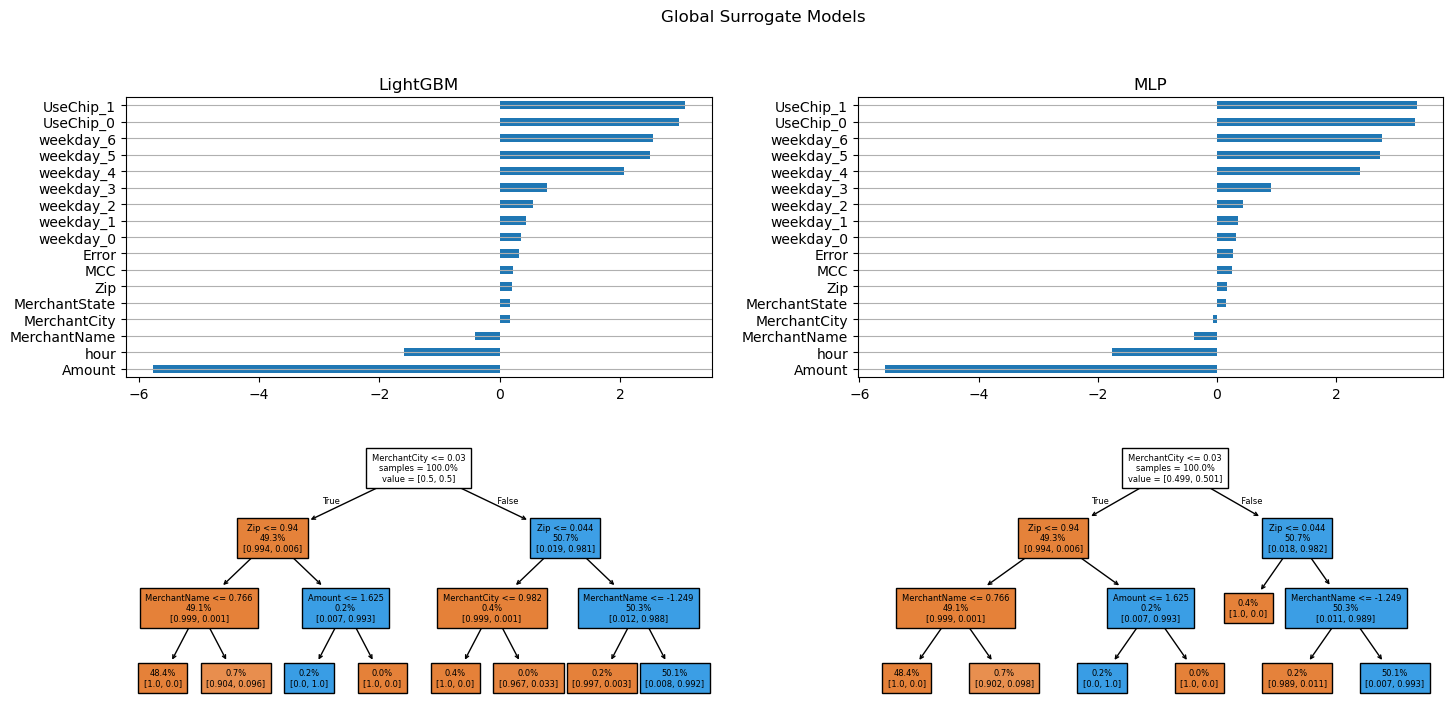

In [201]:
fig, ax = plt.subplots(2, 2, figsize=(17, 8))

# Global surrogate - logistic regression
for i, m in enumerate(list(model.keys())[1:]):
    # LR surrogate
    pd.DataFrame([X_train.columns, lr_surrogate[m].surrogate.coef_[0]], 
                 index=['Features', 'LRcoeff']).T.sort_values(by='LRcoeff').plot(kind='barh', legend=False, 
                                                                                 title=model_name[m], ax=ax[0,i])
    ax[0,i].set_yticklabels(X_train.columns)
    ax[0,i].grid(axis='y')

# Global surrogate - decision tree

# LGBM
tree.plot_tree(dt_surrogate['lgbm'].surrogate,
               feature_names=X_train.columns,
               max_depth=3, 
               filled=True,
               impurity=False,
               label='root',
               proportion=True,
               fontsize=6,
               ax=ax[1,0]
              )
# ax[1,0].set_title('LightGBM', loc='left', x=0.1, y=0.9)

# MLP
tree.plot_tree(dt_surrogate['mlp'].surrogate,
               feature_names=X_train.columns,
               max_depth=3, 
               filled=True,
               impurity=False,
               label='root',
               proportion=True,
               class_names=None,
               fontsize=6,
               ax=ax[1,1]
              )
# ax[1,1].set_title('MLP', loc='left', x=0.1, y=0.9)

plt.suptitle('Global Surrogate Models', y=.99)
plt.subplots_adjust(wspace=0.25)
plt.savefig(fig_folder+'surrogate_models.png', dpi=300, bbox_inches='tight')
plt.show()

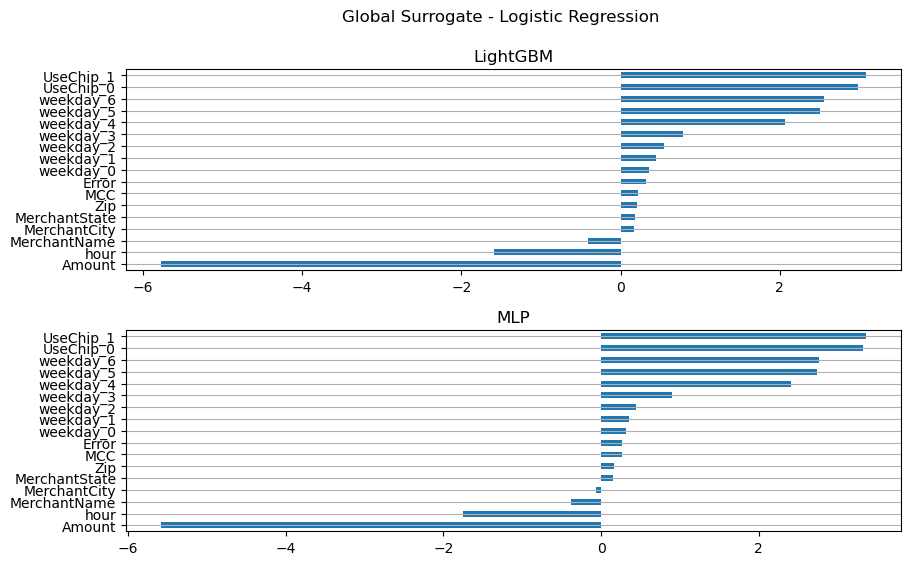

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, m in enumerate(list(model.keys())[1:]):
    # LR surrogate
    pd.DataFrame([X_train.columns, lr_surrogate[m].surrogate.coef_[0]], 
                 index=['Features', 'LRcoeff']).T.sort_values(by='LRcoeff').plot(kind='barh', legend=False, 
                                                                                 title=model_name[m], ax=ax[i])
    ax[i].set_yticklabels(X_train.columns)
    ax[i].grid(axis='y')

plt.subplots_adjust(hspace=0.3)
fig.suptitle('Global Surrogate - Logistic Regression')
plt.show()

## Local methods

### LIME

# Robustness

# main()

In [298]:
%%time

def eval_robustness_perform(years=None, models=None):
    metrics = {m:[] for m in models}
    # Data shift - model performance
    for year in years:
        print(year)
        df = load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)
        # Convert transaction time to datetime
        df.transactionTime = pd.to_datetime(df.transactionTime)
    
        # Split data into Train/Test sets
        X, y = df[var_cols], df['isFraud']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, numerical_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)
    
        # Class imbalance: oversample with SMOTE to treat class imbalance
        smote = SMOTE(sampling_strategy='auto', random_state=1)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
        # Train and evaluate models
        # model=dict()
        for m in models:#model_dict:
            print(m)
            # Train
            model = model_training(X_train, y_train, model_dict[m])
            # # Evaluate
            # robustness_metrics[m][year] = evaluate_model(model, X_test, y_test)
    
            # Model predictions
            pred = model.predict(X_test)
            
            # Metrics
            metrics[m].append([year, 
                               recall_score(y_test, pred), 
                               precision_score(y_test, pred),
                               f1_score(y_test, pred)
                              ])
            
            print('ok')
        print('year ok\n')
    
    for m in models:
        df = pd.DataFrame(metrics[m], columns=['year', 'recall', 'precision', 'f1'])
        df['year'] = df['year'].astype(str)
        metrics[m] = df
    
    return metrics
    

CPU times: user 5 μs, sys: 2 μs, total: 7 μs
Wall time: 10.7 μs


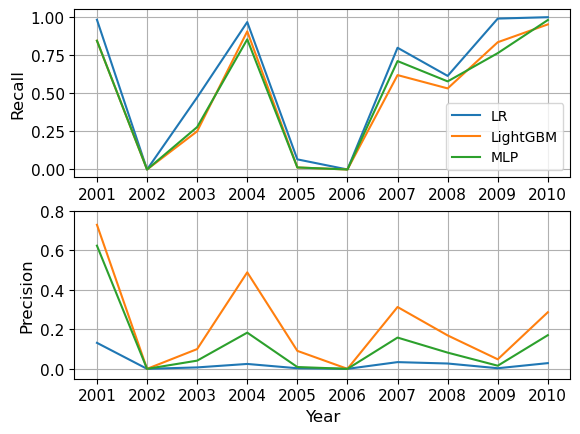

In [351]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm[m].year
    rec = robust_perfm[m].recall
    prec = robust_perfm[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

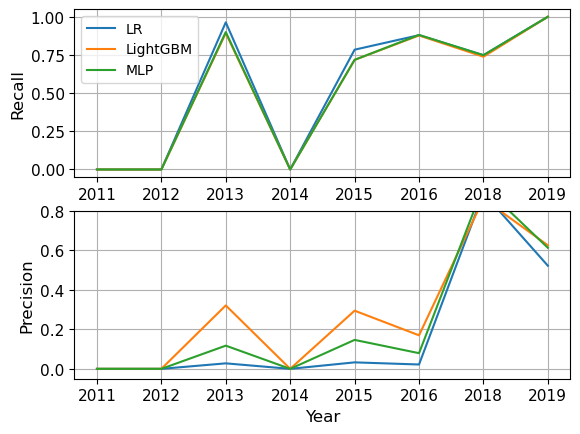

In [352]:
axis_label_fs = 12
axis_tick_fs = 11
legend_fs = 10

fig, ax = plt.subplots(2, 1)
for m in models:
    y = robust_perfm2[m].year
    rec = robust_perfm2[m].recall
    prec = robust_perfm2[m].precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec)

ax[0].legend(fontsize=legend_fs)
ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=0.8, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()

plt.show()

In [354]:
robust_perfm['lr']

year    recall  precision
0  2001  0.980392   0.131579
1  2002  0.000000   0.000000
2  2003  0.472222   0.007234
3  2004  0.965217   0.024777
4  2005  0.066225   0.002987
5  2006  0.000000   0.000000
6  2007  0.796992   0.034007
7  2008  0.612795   0.026948
8  2009  0.988095   0.003066
9  2010  0.997147   0.028927

In [355]:
robust_perfm2['lr']

year    recall  precision
0  2011  0.000000   0.000000
1  2012  0.000000   0.000000
2  2013  0.963415   0.027766
3  2014  0.000000   0.000000
4  2015  0.784383   0.032764
5  2016  0.879371   0.021975
6  2018  0.748333   0.889109
7  2019  1.000000   0.521739

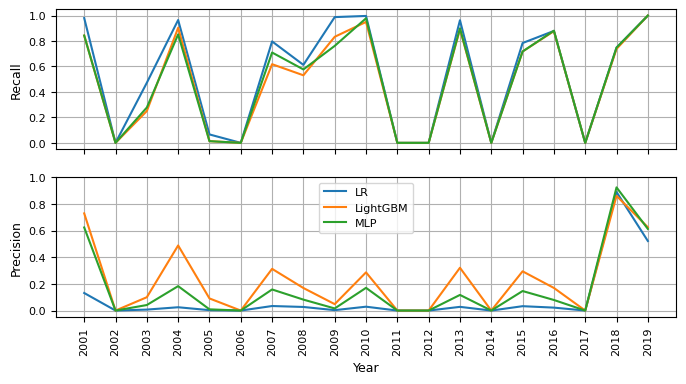

In [376]:
axis_label_fs = 9
axis_tick_fs = 8
legend_fs = 8
title_fs = 9

fig, ax = plt.subplots(2, 1, figsize=(8, 4))
for m in models:
    df = pd.concat([robust_perfm[m], robust_perfm2[m]])
    df = pd.concat([df, pd.DataFrame([['2017', 0, 0]], columns=df.columns)]).sort_values(by='year')
    y = df.year
    rec = df.recall
    prec = df.precision

    # Recall
    ax[0].plot(y, rec, label=model_name[m])

    # Precision
    ax[1].plot(y, prec, label=model_name[m])

# Formatting

ax[0].set_ylim(bottom=-0.05, top=1.05)
ax[0].set_ylabel('Recall', fontsize=axis_label_fs)
ax[0].tick_params(labelsize=axis_tick_fs)
ax[0].grid()

ax[1].set_ylim(top=1, bottom=-0.05)
ax[1].set_ylabel('Precision', fontsize=axis_label_fs)
ax[1].set_xlabel('Year', fontsize=axis_label_fs)
ax[1].tick_params(labelsize=axis_tick_fs)
ax[1].grid()
ax[1].legend(fontsize=legend_fs)

ax[0].set_xticks(df.year, ['' for i in df.year])
ax[1].set_xticks(df.year, df.year, rotation=90)

plt.savefig(fig_folder+'performance_robustness.png', dpi=300, bbox_inches='tight')
plt.show()

In [306]:
%%time
years = [2001+i for i in range(10)]
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm = eval_robustness_perform(years=years, models=models)

2001
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 206095, number of negative: 206095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 412190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2002
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 280566, number of negative: 280566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 561132, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2003
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 372851, number of negative: 372851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3638
[LightGBM] [Info] Number of data points in the train set: 745702, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2004
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 477097, number of negative: 477097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 954194, number of used features: 16
[Lig

/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 725916, number of negative: 725916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3345
[LightGBM] [Info] Number of data points in the train set: 1451832, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2007
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 850370, number of negative: 850370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3884
[LightGBM] [Info] Number of data points in the train set: 1700740, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2008
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 975949, number of negative: 975949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3485
[LightGBM] [Info] Number of data points in the train set: 1951898, number of used features: 16
[L

In [307]:
robust_perfm['lr']

year    recall  precision
0  2001  0.980392   0.131579
1  2002  0.000000   0.000000
2  2003  0.472222   0.007234
3  2004  0.965217   0.024777
4  2005  0.066225   0.002987
5  2006  0.000000   0.000000
6  2007  0.796992   0.034007
7  2008  0.612795   0.026948
8  2009  0.988095   0.003066
9  2010  0.997147   0.028927

In [336]:
[2011+i for i in range(9) if i != 6]

[2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019]

In [339]:
%%time
years = [2011+i for i in range(9) if i != 6] # do not include 2017, no fraud cases
models = ['lr', 'lgbm', 'mlp']
metrics = []
robust_perfm2 = eval_robustness_perform(years=years, models=models)

2011
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1256385, number of negative: 1256385
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 2512770, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2012
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1287330, number of negative: 1287330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 2574660, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2013
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1319453, number of negative: 1319453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4076
[LightGBM] [Info] Number of data points in the train set: 2638906, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2014
lr


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
lgbm
[LightGBM] [Info] Number of positive: 1336822, number of negative: 1336822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4078
[LightGBM] [Info] Number of data points in the train set: 2673644, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
mlp


/Users/efonesca.dos.reis/miniconda3/envs/mrm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ok
year ok

2015
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1358942, number of negative: 1358942
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3905
[LightGBM] [Info] Number of data points in the train set: 2717884, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
year ok

2016
lr
ok
lgbm
[LightGBM] [Info] Number of positive: 1364132, number of negative: 1364132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4121
[LightGBM] [Info] Number of data points in the train set: 2728264, number of used features: 1

In [340]:
robust_perfm2['lr']

year    recall  precision
0  2011  0.000000   0.000000
1  2012  0.000000   0.000000
2  2013  0.963415   0.027766
3  2014  0.000000   0.000000
4  2015  0.784383   0.032764
5  2016  0.879371   0.021975
6  2018  0.748333   0.889109
7  2019  1.000000   0.521739

In [ ]:
def evaluate_model2(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained for data shift robustness. '''
    
    # Model predictions
    pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred)
    }

    return metrics

In [ ]:
()

# Prepare data for TabularBench

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257998 entries, 0 to 257997
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transactionTime  257998 non-null  datetime64[ns]
 1   year             257998 non-null  int64         
 2   month            257998 non-null  int64         
 3   weekday          257998 non-null  int64         
 4   hour             257998 non-null  int64         
 5   User             257998 non-null  int64         
 6   Card             257998 non-null  int64         
 7   Amount           257998 non-null  float64       
 8   UseChip          257998 non-null  object        
 9   MerchantName     257998 non-null  object        
 10  MerchantCity     257998 non-null  object        
 11  MerchantState    257998 non-null  object        
 12  Zip              257998 non-null  object        
 13  MCC              257998 non-null  object        
 14  Error            257

In [25]:
cat_vars

['hour',
 'MerchantName',
 'MerchantCity',
 'MerchantState',
 'Zip',
 'MCC',
 'Error',
 'weekday',
 'UseChip']

# Archive

In [ ]:
# def fixed_train_fixed_test(df: pd.DataFrame, period: str=None, tw: int=None):
#     epoch={}
#     t0 = df[period].min()
#     num_periods = df[period].nunique()
#     num_epochs = int(num_periods/tw)-1
#     for E in range(num_epochs):
#         epoch[E] = {}
#         train_start = t0 + E*tw
#         train_end = train_start + (tw-1)
        
#         test_start = train_end + 1
#         test_end = test_start + (tw-1)
    
#         epoch[E]['train_start'] = train_start
#         epoch[E]['train_end'] = train_end
#         epoch[E]['test_start'] = test_start
#         epoch[E]['test_end'] = test_end
        
#     return epoch

# def increase_train_fixed_test(df: pd.DataFrame, period: str=None, tw: int=None):
#     epoch={}
#     t0 = df[period].min()
#     num_periods = df[period].nunique()
#     num_epochs = int(num_periods/tw)-1
#     for e in range(num_epochs):
        
#         train_start = t0
#         train_end = t0 + e*tw + (tw-1)
        
#         test_start = train_end + 1
#         test_end = test_start + (tw-1)
        
#         epoch[e] = {}
#         epoch[e]['train_start'] = train_start
#         epoch[e]['train_end'] = train_end
#         epoch[e]['test_start'] = test_start
#         epoch[e]['test_end'] = test_end
#         # print(epoch[e])
        
#     return epoch

# def plot_fraud_old(data, tw=None):

#     axis_label_fs = 9
#     axis_tick_fs = 8
#     legend_fs = 8
#     title_fs = 9
    
#     fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    
    
#     # Number and value of fraud
#     x = data.groupby(tw, as_index=True)['isFraud'].sum()
#     y = data.loc[data.isFraud == 1].groupby(tw)['Amount'].sum()
#     if tw == 'week':
#         x.index = x.index.start_time
#         y.index = y.index.start_time
#     ax[0].bar(x.index, x.values, label='No. of fraud')
#     ax01 = ax[0].twinx()
#     ax01.plot(y.index, y.values/1e3, c='tab:red', marker='o', label='Total amount')
    
#     # Class imbalance
#     fraud_imb = 100*data.groupby(tw)['isFraud'].sum()/data.groupby(tw)['isFraud'].count()
#     if tw == 'week':
#         fraud_imb.index = fraud_imb.index.start_time
#     ax[1].plot(fraud_imb.index, fraud_imb.values)
    
#     # Total number of transactions
#     ntx = data.groupby(tw)['isFraud'].count()
#     if tw == 'week':
#         ntx.index = ntx.index.start_time
#     ax[2].bar(ntx.index, ntx.values/1e3)
    
    
#     # Formatting
    
#     ax[0].set_ylabel('No. of fraud', fontsize=axis_label_fs)
#     ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=legend_fs)
#     ax[0].set_title('(a)', fontsize=title_fs, loc='left')
#     ax01.set_ylabel('Fraud value '+r'$(\times 10^3 \$)$', fontsize=axis_label_fs)
#     ax01.legend(loc='upper left', bbox_to_anchor=(0.01, 0.83), fontsize=legend_fs)
    
#     ax[1].grid(axis='both')
#     ax[1].set_title('(b)', loc='left', fontsize=title_fs)
#     ax[1].set_ylabel('Class imbalance (%)', fontsize=axis_label_fs)
    
#     ax[2].set_ylabel('No. of transactions '+r'$(\times 10^3)$', fontsize=axis_label_fs)
#     ax[2].set_title('(c)', loc='left', fontsize=title_fs)
#     ax[2].set_xlabel(tw, fontsize=axis_label_fs)
    
    
#     ax[0].set_xticks(x.index, x.index, rotation=90, fontsize=axis_tick_fs)
#     ax01.set_yticks(np.arange(7), np.arange(7))
#     ax[1].set_xticks(x.index, x.index, rotation=90, fontsize=axis_tick_fs)
#     # if tw == 'week':
#     #     xindex = x.index.date
#     #     [x.index.date if tw=='week' else x.index]
#     ax[2].set_xticks(x.index, x.index.date if tw=='week' else x.index, rotation=90, fontsize=axis_tick_fs)
    
#     ax[0].tick_params(labelsize=axis_tick_fs)
#     ax01.tick_params(labelsize=axis_tick_fs)
#     ax[1].tick_params(labelsize=axis_tick_fs)
#     ax[2].tick_params(labelsize=axis_tick_fs)
    
#     # xlim=[1996, 2019]
#     # ax[0].set_xlim(xlim)
#     # ax[0].set_xlim(xlim)
    
#     plt.subplots_adjust(hspace=0.3)
#     # plt.savefig(fig_folder+'TabFormer_dataset.png', bbox_inches='tight', dpi=300)
#     plt.show()

# def eval_tw(df: pd.DataFrame, 
#             period: str=None,
#             tw: int=None, 
#             L_tw: int=None, 
#             R_tw: int=None, 
#             protocol: str=None,
#             numerical_vars: list[str]=None,
#             target_enc_vars: list[str]=None, 
#             freq_enc_vars: list[str]=None, 
#             onehot_enc_vars: list[str]=None,
#             geo_vars: list[str]=None,
#             under_sample: bool=True,
#             under_sample_ratio: Union[float, str] = 'auto',
#             over_sample: bool=False,
#             over_sample_ratio: Union[float, str] = 'auto',
#            ) -> dict[int, dict[str, dict[str, Union[np.array, float, str]]]]:

#     # All Features
#     var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
#     # Categorical variables
#     cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
#     # Define epoch
#     if protocol == 'fixed_train_fixed_test':
#         epoch = fixed_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'increase_train_fixed_test':
#         epoch = increase_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'retrain_lookback':
#         epoch = retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)
#     else:
#         raise ValueError(f'Protocol {protocol} is not defined.')
    
#     # Evaluate epochs
#     metrics={}
#     for e in epoch:
#         # print(f'Epoch {e}')
#         # Split data into Train/Test sets
#         train_start = epoch[e]['train_start']
#         train_end = epoch[e]['train_end']
#         df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
#         X_train = df_train[var_cols]
#         y_train = df_train['isFraud']
    
#         test_start = epoch[e]['test_start']
#         test_end = epoch[e]['test_end']
#         df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
#         X_test = df_test[var_cols]
#         y_test = df_test['isFraud']

#         if (y_train.sum() == 0) or (y_test.sum() == 0):
#             print(f'Train epoch: start = {train_start}, end = {train_end}')
#             print(f'Train fraud cases: {y_train.sum()}')
#             print(f'Test epoch: start = {test_start}, end = {test_end}')
#             print(f'Test fraud cases: {y_test.sum()}')
#             continue
    
#         # Class imbalance
#         X_train, y_train = class_imbalance(X_train, y_train, 
#                                            under_sample=under_sample,
#                                            under_sample_ratio=under_sample_ratio, 
#                                            over_sample=over_sample,
#                                            over_sample_ratio=over_sample_ratio,
#                                            geo_vars=geo_vars,
#                                            cat_vars=cat_vars
#                                           )
#         # # Debug
#         # print(f'Train epoch: start = {train_start}, end = {train_end}')
#         # print(f'Train fraud cases: {y_train.sum()}')
#         # print(f'Test epoch: start = {test_start}, end = {test_end}')
#         # print(f'Test fraud cases: {y_test.sum()}')
        
#         # Encode and scale data
#         X_train, X_test = encode_scale_data(X_train, X_test, y_train, numerical_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)
    
#         # Model Training and Evaluation
#         # for m in model_dict:
#         metrics[e]={}
#         for m in ['lgbm']:
#             # print(m)
#             model = model_training(X_train, y_train, model_dict[m])
#             metrics[e][m] = evaluate_model(model, X_test, y_test)
#             # print('ok')
            
#     return metrics

# def global_eval_tw_old(df: pd.DataFrame, 
#                    period: str=None,
#                    tw: int=None, 
#                    L_tw: int=None, 
#                    R_tw: int=None, 
#                    protocol: str=None,
#                    model: Model=None,
#                    numerical_vars: list[str]=None,
#                    target_enc_vars: list[str]=None, 
#                    freq_enc_vars: list[str]=None, 
#                    onehot_enc_vars: list[str]=None,
#                    geo_vars: list[str]=None,
#                    under_sample: bool=True,
#                    under_sample_ratio: Union[float, str] = 'auto',
#                    over_sample: bool=False,
#                    over_sample_ratio: Union[float, str] = 'auto',
#                   ) -> dict[str, float]:

#     # All Features
#     var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
#     # Categorical variables
#     cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
#     # Define epoch
#     if protocol == 'fixed_train_fixed_test':
#         epoch = fixed_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'increase_train_fixed_test':
#         epoch = increase_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'retrain_lookback':
#         epoch = retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)
#     else:
#         raise ValueError(f'Protocol {protocol} is not defined.')

#     # Model predictions
#     pred = []

#     # Concatenation of all test sets for each epoch
#     global_y_test = []

#     # Log of the skipped epochs due to no fraud cases
#     skipped_epochs=[]
    
#     # Evaluate epochs
#     for e in epoch:
        
#         # Split data into Train/Test sets
#         train_start = epoch[e]['train_start']
#         train_end = epoch[e]['train_end']
#         df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
#         X_train = df_train[var_cols]
#         y_train = df_train['isFraud']
    
#         test_start = epoch[e]['test_start']
#         test_end = epoch[e]['test_end']
#         df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
#         X_test = df_test[var_cols]
#         y_test = df_test['isFraud']

#         # Skip epochs with no fraud cases in test or train
#         if (y_train.sum() == 0) or (y_test.sum() == 0):
#             skipped_epochs.append([train_start, train_end, test_start, test_end, y_train.sum(), y_test.sum()])
#             continue
    
#         # Class imbalance
#         X_train, y_train = class_imbalance(X_train, y_train, 
#                                            under_sample=under_sample,
#                                            under_sample_ratio=under_sample_ratio, 
#                                            over_sample=over_sample,
#                                            over_sample_ratio=over_sample_ratio,
#                                            geo_vars=geo_vars,
#                                            cat_vars=cat_vars
#                                           )
        
#         # Encode and scale data
#         X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
#                                             numerical_vars, target_enc_vars, 
#                                             freq_enc_vars, onehot_enc_vars)


#         # Train model
#         model_trained = model_training(X_train, y_train, model)

#         # Model predictions
#         pred.append(model_trained.predict(X_test))

#         # Global test set
#         global_y_test.append(y_test)
    
#     # Concatenate results
#     pred = np.concatenate(pred)
#     y_test = pd.concat(global_y_test)

#     # Compute metrics
#     metrics = {
#         'recall': recall_score(y_test, pred),
#         'precision': precision_score(y_test, pred),
#         'f1': f1_score(y_test, pred),
#     }

#     # Log of skipped epochs
#     skipped_epochs = pd.DataFrame(skipped_epochs, columns=['train_start', 'train_end', 'test_start', 
#                                                            'test_end', 'train_fraud_cases', 'test_fraud_cases'])
    
#     return metrics, skipped_epochs

# def global_eval_tw_old(df: pd.DataFrame, 
#                    period: str=None,
#                    tw: int=None, 
#                    L_tw: int=None, 
#                    R_tw: int=None, 
#                    protocol: str=None,
#                    model: Model=None,
#                    numerical_vars: list[str]=None,
#                    target_enc_vars: list[str]=None, 
#                    freq_enc_vars: list[str]=None, 
#                    onehot_enc_vars: list[str]=None,
#                    geo_vars: list[str]=None,
#                    under_sample: bool=True,
#                    under_sample_ratio: Union[float, str] = 'auto',
#                    over_sample: bool=False,
#                    over_sample_ratio: Union[float, str] = 'auto',
#                   ) -> dict[str, float]:

#     # All Features
#     var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
#     # Categorical variables
#     cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
#     # Define epoch
#     if protocol == 'fixed_train_fixed_test':
#         epoch = fixed_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'increase_train_fixed_test':
#         epoch = increase_train_fixed_test(df, period=period, tw=tw)
#     elif protocol == 'retrain_lookback':
#         epoch = retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)
#     else:
#         raise ValueError(f'Protocol {protocol} is not defined.')

#     # Model predictions
#     pred = []

#     # Concatenation of all test sets for each epoch
#     global_y_test = []

#     # Log of the skipped epochs due to no fraud cases
#     skipped_epochs=[]
    
#     # Evaluate epochs
#     for e in epoch:
        
#         # Split data into Train/Test sets
#         train_start = epoch[e]['train_start']
#         train_end = epoch[e]['train_end']
#         df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
#         X_train = df_train[var_cols]
#         y_train = df_train['isFraud']
    
#         test_start = epoch[e]['test_start']
#         test_end = epoch[e]['test_end']
#         df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
#         X_test = df_test[var_cols]
#         y_test = df_test['isFraud']

#         # Skip epochs with no fraud cases in test or train
#         if (y_train.sum() == 0) or (y_test.sum() == 0):
#             skipped_epochs.append([train_start, train_end, test_start, test_end, y_train.sum(), y_test.sum()])
#             continue
    
#         # Class imbalance
#         X_train, y_train = class_imbalance(X_train, y_train, 
#                                            under_sample=under_sample,
#                                            under_sample_ratio=under_sample_ratio, 
#                                            over_sample=over_sample,
#                                            over_sample_ratio=over_sample_ratio,
#                                            geo_vars=geo_vars,
#                                            cat_vars=cat_vars
#                                           )
        
#         # Encode and scale data
#         X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
#                                             numerical_vars, target_enc_vars, 
#                                             freq_enc_vars, onehot_enc_vars)


#         # Train model
#         model_trained = model_training(X_train, y_train, model)

#         # Model predictions
#         pred.append(model_trained.predict(X_test))

#         # Global test set
#         global_y_test.append(y_test)
    
#     # Concatenate results
#     pred = np.concatenate(pred)
#     y_test = pd.concat(global_y_test)

#     # Compute metrics
#     metrics = {
#         'recall': recall_score(y_test, pred),
#         'precision': precision_score(y_test, pred),
#         'f1': f1_score(y_test, pred),
#     }

#     # Log of skipped epochs
#     skipped_epochs = pd.DataFrame(skipped_epochs, columns=['train_start', 'train_end', 'test_start', 
#                                                            'test_end', 'train_fraud_cases', 'test_fraud_cases'])
    
#     return metrics, skipped_epochs

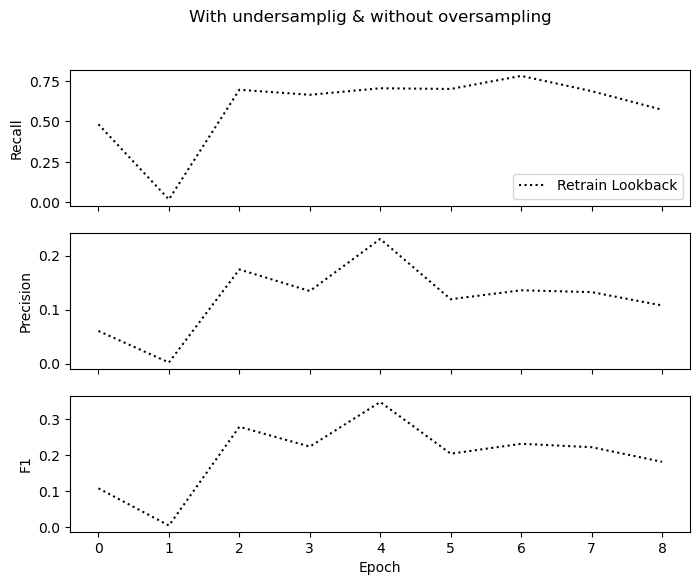

In [343]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# # Fixed train fixed test
# rec = [fixtrain_metrics[e]['lgbm']['recall_score'] for e in fixtrain_metrics]
# pre = [fixtrain_metrics[e]['lgbm']['precision_score'] for e in fixtrain_metrics]
# f1 = [fixtrain_metrics[e]['lgbm']['f1_score'] for e in fixtrain_metrics]

# ax[0].plot(rec, label='Fixed train', color='C0')
# ax[1].plot(pre, label='Precision', color='C1')
# ax[2].plot(f1, label='F1', color='C2')

# # Increase train fixed test
# rec = [inctrain_metrics[e]['lgbm']['recall_score'] for e in inctrain_metrics]
# pre = [inctrain_metrics[e]['lgbm']['precision_score'] for e in inctrain_metrics]
# f1 = [inctrain_metrics[e]['lgbm']['f1_score'] for e in inctrain_metrics]

# ax[0].plot(rec, label='Increasing train', ls='--', color='C0')
# ax[1].plot(pre, label='Precision', ls='--', color='C1')
# ax[2].plot(f1, label='F1', ls='--', color='C2')

# Retrain Lookback
rec = [retrain_lookback_metrics[e]['lgbm']['recall_score'] for e in retrain_lookback_metrics]
pre = [retrain_lookback_metrics[e]['lgbm']['precision_score'] for e in retrain_lookback_metrics]
f1 = [retrain_lookback_metrics[e]['lgbm']['f1_score'] for e in retrain_lookback_metrics]

ax[0].plot(rec, label='Retrain Lookback', ls=':', color='k')
ax[1].plot(pre, label='Precision', ls=':', color='k')
ax[2].plot(f1, label='F1', ls=':', color='k')

# Formatting
ax[0].set_ylabel('Recall')
ax[1].set_ylabel('Precision')
ax[2].set_ylabel('F1')
ax[2].set_xlabel('Epoch')

ax[0].legend()

fig.suptitle('With undersamplig & without oversampling')

plt.show()

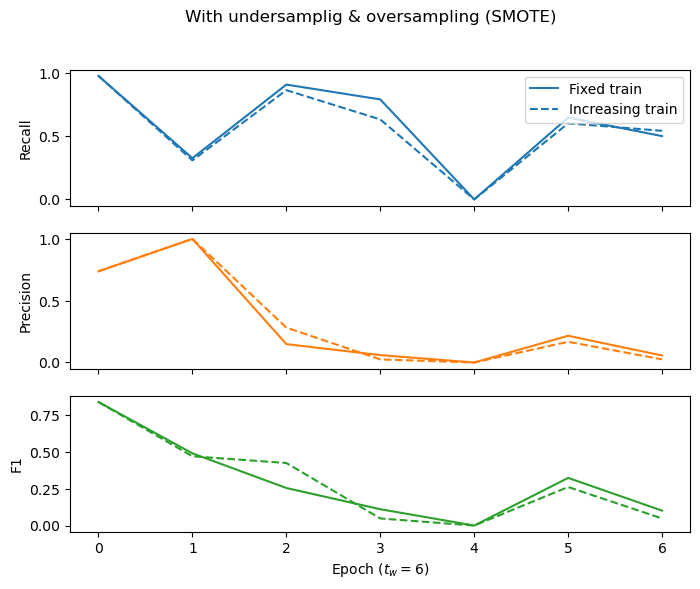

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Fixed train fixed test
rec = [fixtrain_metrics[e]['lgbm']['recall_score'] for e in fixtrain_metrics]
pre = [fixtrain_metrics[e]['lgbm']['precision_score'] for e in fixtrain_metrics]
f1 = [fixtrain_metrics[e]['lgbm']['f1_score'] for e in fixtrain_metrics]

ax[0].plot(rec, label='Fixed train', color='C0')
ax[1].plot(pre, label='Precision', color='C1')
ax[2].plot(f1, label='F1', color='C2')

# Increase train fixed test
rec = [inctrain_metrics[e]['lgbm']['recall_score'] for e in inctrain_metrics]
pre = [inctrain_metrics[e]['lgbm']['precision_score'] for e in inctrain_metrics]
f1 = [inctrain_metrics[e]['lgbm']['f1_score'] for e in inctrain_metrics]

ax[0].plot(rec, label='Increasing train', ls='--', color='C0')
ax[1].plot(pre, label='Precision', ls='--', color='C1')
ax[2].plot(f1, label='F1', ls='--', color='C2')

ax[0].set_ylabel('Recall')
ax[1].set_ylabel('Precision')
ax[2].set_ylabel('F1')
ax[2].set_xlabel('Epoch '+r'($t_w=$'+f'{tw})')

ax[0].legend()

fig.suptitle('With undersamplig & oversampling (SMOTE)')

plt.show()

# Debug

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torcheval.metrics.classification import BinaryRecall, BinaryPrecision, BinaryF1Score, BinaryAccuracy
from fraudmrm.utils import TrainData, TestData


class BinaryMLP1L(nn.Module):
    def __init__(self, 
                 input_size: int,
                 layer1_size: int=128,
                 learning_rate: float=1e-3,
                 max_epochs: int=200,
                 batch_size: int=64,
                 tol: float=1e-4,
                 n_consec_iter: int=10,
                 verbose: bool=True,
                 random_state: int=None,
                ) -> None:
        super().__init__()

        # Set random seed for reproducibility
        if random_state:
            self.set_random_seed(random_state)
        
        # Training parameters
        self.input_size = input_size
        self.layer1_size = layer1_size
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.tol = tol
        self.n_consec_iter = n_consec_iter
        self.verbose = verbose

        # Layers
        self.layer1 = nn.Linear(self.input_size, self.layer1_size)
        self.layer_out = nn.Linear(self.layer1_size, 1)
        # Activation, Dropout, and Batch Normalisation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(self.layer1_size)

    def set_random_seed(self, seed: int):
        """
        Sets the seed for reproducibility.
        """
        # Set the random seed for Python's random module, NumPy, and PyTorch
        # random.seed(seed) # Uncomment if using module random
        np.random.seed(seed)
        torch.manual_seed(seed)  # CPU
        torch.cuda.manual_seed(seed)  # GPU (if available)
        torch.cuda.manual_seed_all(seed)  # All GPUs
        # torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
        # torch.backends.cudnn.benchmark = False  # Disable the auto-tuner for deterministic behavior

    def forward(self, x):
        # Layer 1
        x = self.relu(self.layer1(x))
        # x = self.batchnorm1(x)
        x = self.dropout(x)
        # Output layer
        x = self.layer_out(x)

        return x

    # Modified version of .fit() for pd.DataFrame
    # def fit(self, train_loader: DataLoader):
    def fit(self, X_train: pd.DataFrame, y_train: pd.DataFrame):
        # Send model to device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)

        # Train DataLoader
        train_data = TrainData(torch.tensor(X_train.values, dtype=torch.float32), 
                   torch.tensor(y_train.values, dtype=torch.float32))
        train_loader = DataLoader(dataset=train_data, batch_size=self.batch_size, shuffle=True)
        if self.verbose: print(f'Train loader size: {len(train_loader)} batches')

        # Loss and Optimizer
        loss_function = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Stop criterion variables
        avg_loss_old, count_iter = float('inf'), 0

        # Initialize metrics
        recall = BinaryRecall().to(device)
        precision = BinaryPrecision().to(device)
        f1 = BinaryF1Score().to(device)
        accuracy = BinaryAccuracy().to(device)

        # Training loop
        self.train()
        for e in range(1, self.max_epochs+1):
            epoch_loss = 0
            
            # Reset epoch loss and metrics
            recall.reset()
            precision.reset()
            f1.reset()
            accuracy.reset()
        
            for X_batch, y_batch in train_loader:
                # Send data to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                y_logit = self(X_batch)
                y_pred_prob = torch.sigmoid(y_logit)
                y_pred = torch.round(y_pred_prob)

                if y_pred_prob.shape != y_batch.shape:
                    print('-'*50)
                    print('-'*50)
                    print('-'*50)
                print(f'y_pred_prob: {y_pred_prob.shape} y_pred_prob.squeeze(): {y_pred_prob.squeeze().shape}, y_batch: {y_batch.shape}')

                # Compute metrics
                recall.update(y_pred_prob.squeeze(), y_batch.int())
                precision.update(y_pred_prob.squeeze(), y_batch.int())
                f1.update(y_pred_prob.squeeze(), y_batch.int())
                accuracy.update(y_pred_prob.squeeze(), y_batch.int())


In [56]:
mlpdebug = Model(name='mlp', arc=BinaryMLP1L,
            parameters=dict(input_size=X_train.shape[1], 
                            layer1_size=128,
                            learning_rate=1e-3, 
                            max_epochs=100, 
                            verbose=False, 
                            random_state=1))

In [24]:
def generate_retrain_lookback_epochs(df: pd.DataFrame, 
                                     period: str=None,
                                     L_tw: int=None,
                                     R_tw: int=None,
                                    ) -> dict[int, dict[str, pd.arrays.PeriodArray]]:
    """ 
        Parameters:
        df (pd.DataFrame): Dataframe of the transactions.
        period (str): Column with the calendar period (D, W, M, Y) to compute the epochs.
        R_tw (int): Retrain time window length.
        L_tw (int): Lookback time window lenght.
    """
    epoch={}

    # Beginning and ending of the dataset
    T0 = df[period].min()
    Tf = df[period].max()

    # First training time
    t0 = T0 + L_tw

    # Number of retrain epochs
    N = int(np.ceil((Tf - t0).n / R_tw))

    for n in range(N):
        t = t0 + n * R_tw
        train_start = t - L_tw
        train_end = t - 1
        test_start = t
        test_end = min(t + (R_tw  - 1), Tf)

        epoch[n] = {}
        epoch[n]['train_start'] = train_start
        epoch[n]['train_end'] = train_end
        epoch[n]['test_start'] = test_start
        epoch[n]['test_end'] = test_end
    
    return epoch

In [25]:
def epoch_train_test_split(df: pd.DataFrame, 
                           period: str, 
                           epoch: Dict[str, pd.arrays.PeriodArray], 
                           var_cols: List[str], 
                           target_var: str,
                          ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Splits dataset into train and test sets for a given epoch."""
    
    # Train set
    train_start = epoch['train_start']
    train_end = epoch['train_end']
    df_train = df.loc[(df[period]>=train_start)&(df[period]<=train_end)]
    X_train = df_train[var_cols]
    y_train = df_train[target_var]
    
    # Test set
    test_start = epoch['test_start']
    test_end = epoch['test_end']
    df_test = df.loc[(df[period]>=test_start)&(df[period]<=test_end)]
    X_test = df_test[var_cols]
    y_test = df_test[target_var]

    return X_train, X_test, y_train, y_test

In [26]:
def global_eval_tw(df: pd.DataFrame, 
                   period: str=None,
                   tw: int=None, 
                   L_tw: int=None, 
                   R_tw: int=None, 
                   model: Model=None,
                   target_var: str=None,
                   numerical_vars: list[str]=None,
                   target_enc_vars: list[str]=None, 
                   freq_enc_vars: list[str]=None, 
                   onehot_enc_vars: list[str]=None,
                   geo_vars: list[str]=None,
                   under_sample: bool=True,
                   under_sample_ratio: Union[float, str] = 'auto',
                   over_sample: bool=False,
                   over_sample_ratio: Union[float, str] = 'auto',
                  ) -> Tuple[Dict[str, float], int]:
    """Evaluates model performance over retrain and lookback time windows."""

    # All Features
    var_cols = numerical_vars + freq_enc_vars + target_enc_vars + onehot_enc_vars
    # Categorical features
    cat_vars = freq_enc_vars + target_enc_vars + onehot_enc_vars
    
    # Define epochs for retraining and lookback
    epoch = generate_retrain_lookback_epochs(df, period=period, L_tw=L_tw, R_tw=R_tw)

    # Model predictions
    pred = []

    # Concatenation of all test sets for each epoch
    global_y_test = []

    # Log of the skipped epochs due to no fraud cases
    skipped_epochs=0
    
    # Evaluate epochs
    for e in epoch:

        # Reset model before training for the current time window
        model.reset()
        
        # Split Train/Test sets
        X_train, X_test, y_train, y_test = epoch_train_test_split(df, period, epoch[e], var_cols, target_var)

        # Skip epochs with no fraud cases in test or train
        if (y_train.sum() == 0) or (y_test.sum() == 0):
            skipped_epochs += 1
            continue
    
        # Class imbalance
        X_train, y_train = class_imbalance(X_train, y_train, 
                                           under_sample=under_sample,
                                           under_sample_ratio=under_sample_ratio, 
                                           over_sample=over_sample,
                                           over_sample_ratio=over_sample_ratio,
                                           geo_vars=geo_vars,
                                           cat_vars=cat_vars
                                          )
        
        # Encode and scale data
        X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
                                            numerical_vars, target_enc_vars, 
                                            freq_enc_vars, onehot_enc_vars)


        # Train model
        # model_trained = model_training(X_train, y_train, model)
        model.fit(X_train, y_train)


In [27]:
def retrain_lookback_matrix(df: pd.DataFrame, 
                            tw_min: int=1, 
                            tw_max: int=None, 
                            options: Dict=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generates a ndarray of evaluation metrics over paris of different retraining and lookback windows."""

    if tw_max is None:
        raise ValueError('Variable tw_max must be assigned an int value.')

    # Compute metrics for each pair of retrain and lookback time window
    N = tw_max - tw_min + 1
    score_matrix = dict(recall=np.zeros((N, N)), precision=np.zeros((N, N)), f1=np.zeros((N, N)))
    skipped_epochs = 0
    for L in range(tw_min, tw_max + 1):
        for R in range(tw_min, tw_max + 1):
            # Compute metrics for each pair (Retrain, Lookback)
            metrics, se = global_eval_tw(df, L_tw=L, R_tw=R, **options)
            skipped_epochs += se
            i, j = L-tw_min, R-tw_min
            score_matrix['recall'][i, j] = metrics['recall']
            score_matrix['precision'][i, j] = metrics['precision']
            score_matrix['f1'][i, j] = metrics['f1']
        
    print(f'Skipped Epochs: {skipped_epochs}')
    return score_matrix


### Evaluate

In [28]:
# Define parameters of evaluation
tw_min = 1
tw_max = 12
eval_options = dict(
    period='month_date',
    target_var = 'isFraud',
    numerical_vars = numerical_vars,
    target_enc_vars = target_enc_vars,
    freq_enc_vars = freq_enc_vars,
    onehot_enc_vars = onehot_enc_vars,
    geo_vars = geo_vars,
    under_sample=True,
    under_sample_ratio = 0.1,
    over_sample=False,
)

In [158]:
a = torch.tensor(np.random.rand(10, 1))

print(a)
print(a.shape)
print(a.squeeze().shape)
print()
print(a.view(-1))
print(a.view(-1).shape)
print()
print(a.squeeze(dim=1))
print(a.squeeze(dim=1).shape)

tensor([[0.5784],
        [0.4081],
        [0.2370],
        [0.9034],
        [0.5737],
        [0.0029],
        [0.6171],
        [0.3266],
        [0.5271],
        [0.8859]], dtype=torch.float64)
torch.Size([10, 1])
torch.Size([10])

tensor([0.5784, 0.4081, 0.2370, 0.9034, 0.5737, 0.0029, 0.6171, 0.3266, 0.5271,
        0.8859], dtype=torch.float64)
torch.Size([10])

tensor([0.5784, 0.4081, 0.2370, 0.9034, 0.5737, 0.0029, 0.6171, 0.3266, 0.5271,
        0.8859], dtype=torch.float64)
torch.Size([10])


In [159]:
b = torch.tensor(np.random.randint(2, size=[10]))

print(b)
print(b.shape)

tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0])
torch.Size([10])


In [160]:
rec = BinaryRecall()
rec.update(a.view(-1), b)
rec.compute().item()

0.6000000238418579

In [57]:
%%time
eval_options['model'] = mlpdebug
mlp_rl_matrix = retrain_lookback_matrix(df, tw_min=tw_min, tw_max=tw_max, options=eval_options)

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
y_pred_prob: torch.Size([64, 1]) y_pred_prob.squeeze(): torch.Size([64]), y_batch: torch.Size([64])
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
y_pred_prob: torch.Size([64, 1]) y_pred_prob.squeeze(): torch.Size([64]), y_batch: torch.Size([64])
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
y_pred_prob: torch.Size([64, 1]) y_pred_prob.squeeze(): torch.Size([64]), y_batch: torch.Size([64])
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
y_pred_prob: torch.Size([64, 1]) y_pred_prob.squeeze(): torch.Size([64]), y_batch: torch

AttributeError: 'BinaryMLP1L' object has no attribute 'predict'

# Logistic Regression

In [138]:
# Models to be evaluated

logistic = Model(name='LR', 
                 arc=LogisticRegression, 
                 parameters=dict(class_weight=None, max_iter=1000, random_state=1, C=1))

model_list = [logistic]

In [139]:
%%time
metrics=dict()
for model in model_list:
    print(f'Training {model.name}')
    model.reset()
    model.fit(X_train, y_train)
    metrics[model.name] = evaluate_model(model, X_test, y_test)
    print('Done\n')

Training LR
Done

CPU times: user 2.41 s, sys: 1.3 s, total: 3.71 s
Wall time: 532 ms


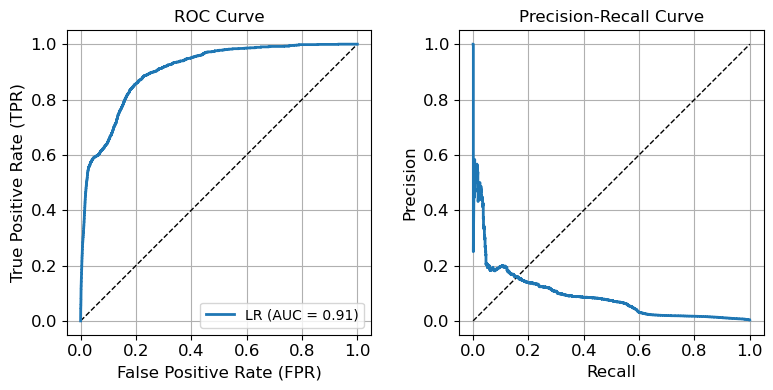

LR
Precision  0.08
Recall     0.47
F1         0.13
ROC-AUC    0.91

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, model in enumerate(model_list):
    m = model.name
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=m, color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

models_metrics=[]
for model in model_list:
    m = model.name
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['roc_auc_score']])

display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR']).round(2).T)